In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from tqdm.notebook import tqdm, trange
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [2]:
#setup input and output formats, load data

file_name = "A_C_OF_ALPHA.csv"
id_cols =["sample_id"] #["db_id", "sample_id"]#["sample_id"]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
model_path = Path('D:/workspace/lazydeep/experiments/1.01/')
log_path = Path("D:/workspace/lazydeep/experiments/1.02")
n_components = 36

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)


D:\workspace\lazydeep\experiments\1.02\A_C_OF_ALPHA


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)

n_features = ncol - 1-len(id_cols)
dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)
print(data.shape)

(7329, 1703)


In [4]:
n_models = 100
model_names = [f"random_{i}" for i in range(0,n_models)]
deep_models = {name:torch.load(model_dir/"models"/name/"_model") for name in model_names}
#for each model, load state
print(f"Loaded {len(deep_models)} models")
#print(deep_models)
for name in model_names:
    sub_path = log_dir / name
    if not sub_path.exists():
        sub_path.mkdir()

Loaded 100 models


In [5]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")

In [6]:
fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
preprocessing = PLSRegression(n_components=n_components)
eval = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
load_fun_pp_cv = lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))

In [7]:
deep_scheme = DeepScheme(None, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=True,update=False)
deep_scores, deep_preds, _ , _, _,_ = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})
    


all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Tested (test) on 1222 instances with mean losses of: random_0:10.7076,random_1:8.82,random_2:18.5217,random_3:9.5714,random_4:8.5565,random_5:6.5993,random_6:7.6571,random_7:8.3455,random_8:10.0416,random_9:9.7644,random_10:9.4256,random_11:257.8883,random_12:14.0352,random_13:257.8896,random_14:11.7894,random_15:9.5401,random_16:14.3834,random_17:13.6174,random_18:18.9218,random_19:14.6448,random_20:39.1621,random_21:11.0764,random_22:16.7366,random_23:11.3506,random_24:8.2135,random_25:10.563,random_26:41.0637,random_27:13.9577,random_28:9.0218,random_29:7.6515,random_30:257.0104,random_31:8.7433,random_32:7.6763,random_33:14.2807,random_34:9.46,random_35:11.1106,random_36:185.2397,random_37:12.1935,random_38:10.1135,random_39:6.8647,random_40:15.7635,random_41:11.1829,random_42:137.3898,random_43:275.1415,random_44:9.7403,random_45:

In [8]:
scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')

for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_5 - deep - 6.5993118223699145 - 6.699335931756102 - 5.808911881224236 - 12.437064430149338 - 17.411863611332222 - 9.790268489036634 - 0.958485857983749
1 - random_6 - deep - 7.657056827201781 - 6.564094499753462 - 9.682900840390618 - 8.210204705949888 - 17.981783471665942 - 10.018255385589088 - 0.9575191142818861
2 - random_99 - deep - 8.878893956810284 - 7.774931539295153 - 6.359399620574776 - 10.877428736284461 - 18.93252708988049 - 10.563903451673058 - 0.9552053767851393
3 - random_71 - deep - 8.978512915378701 - 9.810193436430636 - 7.536236177986513 - 9.99243597140769 - 17.324588967775536 - 10.727956589197204 - 0.9545097344483622
4 - random_1 - deep - 8.820022142070014 - 9.606977017928653 - 6.009644924666821 - 11.45034731278939 - 17.968321699475187 - 10.770552584248263 - 0.9543291126206918
5 - random_59 - deep - 6.5454984639943525 - 6.758544790764292 - 6.103265019540998 - 9.500744471093068 - 25.332817496284903 - 10.84680016087757 - 0.954005796388034
6 - random_83 - deep 

In [9]:
for deep_name,deep_model in tqdm(deep_models.items()):
    #if int(deep_name.replace("random_",""))>=85:
        logging.getLogger().info(f"Running model {deep_name}")
        temp_dict = {deep_name:deep_model}

        lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = setup_pls_models_exh(nrow),n_neighbours=500,loss_fun_sk = mean_squared_error)
        lwr_scores, lwr_preds, _ , _, _,_= eval.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
        lwr_scores_final, lwr_preds_final, _ , _, _,_= eval.build(temp_dict,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

        #scores
        for k,v in ut.flip_dicts(lwr_scores).items():
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores.append({**dict1,**v})

        for k,v in ut.flip_dicts(lwr_scores_final).items():
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores_final.append({**dict1,**v})

        lwr_preds['deep'] = deep_preds[deep_name]
        lwr_preds_final['deep'] = deep_preds_final[deep_name]

        lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
        lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

        #preds
        # todo save predictions - appending solns
        plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)

  0%|          | 0/100 [00:00<?, ?it/s]

Running model random_0'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.2806,lwr_k=10:0.0,lwr_k=20:0.1466,lwr_k=30:1.8565,lwr_k=40:2.9958,lwr_k=50:3.6424,lwr_k=100:4.7932,lwr_k=200:5.6109,lwr_k=300:5.9273,lwr_k=400:6.1253,lwr_k=500:6.2913,lwr_k=600:6.442,lwr_k=700:6.5077,lwr_k=800:6.5856,lwr_k=900:6.6239,lwr_k=1000:6.6726'
Tested (test) on 1222 instances with mean losses of: lr:8.4396,lwr_k=10:63.867,lwr_k=20:14950877.5446,lwr_k=30:56.5157,lwr_k=40:38.5629,lwr_k=50:11.603,lwr_k=100:7.8087,lwr_k=200:7.2414,lwr_k=300:7.3506,lwr_k=400:7.5276,lwr_k=500:7.6354,lwr_k=600:7.693,lwr_k=700:7.7167,lwr_k=800:7.7521,lwr_k=900:7.7968,lwr_k=1000:7.8073'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.7962,lwr_k=10:0.0,lwr_k=20:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_1'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.4501,lwr_k=10:0.0,lwr_k=20:0.0893,lwr_k=30:1.4376,lwr_k=40:2.1544,lwr_k=50:2.4698,lwr_k=100:3.3062,lwr_k=200:3.6581,lwr_k=300:4.0718,lwr_k=400:4.1036,lwr_k=500:4.0128,lwr_k=600:4.0429,lwr_k=700:4.077,lwr_k=800:4.1167,lwr_k=900:4.1328,lwr_k=1000:4.1314'
Tested (test) on 1222 instances with mean losses of: lr:8.2097,lwr_k=10:45.3894,lwr_k=20:597425.9027,lwr_k=30:141169.09,lwr_k=40:7115.8555,lwr_k=50:788.5794,lwr_k=100:11.1512,lwr_k=200:8.8789,lwr_k=300:9.3047,lwr_k=400:8.5475,lwr_k=500:8.3438,lwr_k=600:8.2897,lwr_k=700:8.3793,lwr_k=800:8.3503,lwr_k=900:8.2503,lwr_k=1000:8.7103'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.4414,lwr_k=10:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_2'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.5547,lwr_k=10:0.0,lwr_k=20:0.0198,lwr_k=30:1.7082,lwr_k=40:2.96,lwr_k=50:3.6488,lwr_k=100:5.6975,lwr_k=200:7.2295,lwr_k=300:7.7223,lwr_k=400:8.3304,lwr_k=500:8.6106,lwr_k=600:8.8694,lwr_k=700:9.0405,lwr_k=800:9.2536,lwr_k=900:9.4115,lwr_k=1000:9.6033'
Tested (test) on 1222 instances with mean losses of: lr:14.6005,lwr_k=10:88.1887,lwr_k=20:1102.8928,lwr_k=30:84.707,lwr_k=40:403.114,lwr_k=50:229.9021,lwr_k=100:51.1724,lwr_k=200:11.3332,lwr_k=300:11.2144,lwr_k=400:11.2869,lwr_k=500:11.3756,lwr_k=600:11.6743,lwr_k=700:11.9157,lwr_k=800:12.029,lwr_k=900:12.1336,lwr_k=1000:12.2884'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:14.0798,lwr_k=10:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_3'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.7113,lwr_k=10:3.4732,lwr_k=20:4.734,lwr_k=30:5.2614,lwr_k=40:5.6813,lwr_k=50:5.8998,lwr_k=100:6.4276,lwr_k=200:6.7379,lwr_k=300:6.9017,lwr_k=400:7.0118,lwr_k=500:7.089,lwr_k=600:7.1604,lwr_k=700:7.2366,lwr_k=800:7.281,lwr_k=900:7.3196,lwr_k=1000:7.3479'
Tested (test) on 1222 instances with mean losses of: lr:8.8477,lwr_k=10:127.849,lwr_k=20:12.2591,lwr_k=30:11.2831,lwr_k=40:9.9138,lwr_k=50:8.5542,lwr_k=100:8.0593,lwr_k=200:8.0973,lwr_k=300:8.2026,lwr_k=400:8.3436,lwr_k=500:8.4243,lwr_k=600:8.3175,lwr_k=700:8.268,lwr_k=800:8.3043,lwr_k=900:8.3162,lwr_k=1000:8.3434'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.1858,lwr_k=10:2.0572,lwr_k=20:4.05

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_4'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.5509,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.3014,lwr_k=40:1.4609,lwr_k=50:2.0286,lwr_k=100:3.4643,lwr_k=200:4.2253,lwr_k=300:4.5457,lwr_k=400:4.7246,lwr_k=500:4.8029,lwr_k=600:4.8627,lwr_k=700:4.9286,lwr_k=800:5.0044,lwr_k=900:5.0742,lwr_k=1000:5.1034'
Tested (test) on 1222 instances with mean losses of: lr:8.9244,lwr_k=10:28.3423,lwr_k=20:48.4619,lwr_k=30:101.6311,lwr_k=40:17.1693,lwr_k=50:11.5016,lwr_k=100:8.5109,lwr_k=200:8.5348,lwr_k=300:8.2467,lwr_k=400:8.2332,lwr_k=500:8.2895,lwr_k=600:8.4107,lwr_k=700:8.4586,lwr_k=800:8.4851,lwr_k=900:8.531,lwr_k=1000:8.5632'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:12.9189,lwr_k=10:0.0,lwr_k=20:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_5'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4468,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0251,lwr_k=40:0.7391,lwr_k=50:1.189,lwr_k=100:2.1317,lwr_k=200:2.6149,lwr_k=300:2.7884,lwr_k=400:2.8759,lwr_k=500:2.9515,lwr_k=600:2.9971,lwr_k=700:3.0294,lwr_k=800:3.0587,lwr_k=900:3.0928,lwr_k=1000:3.1158'
Tested (test) on 1222 instances with mean losses of: lr:6.9563,lwr_k=10:23.2112,lwr_k=20:72.3859,lwr_k=30:754.6727,lwr_k=40:26.7953,lwr_k=50:15.1363,lwr_k=100:9.0334,lwr_k=200:7.5109,lwr_k=300:7.229,lwr_k=400:7.041,lwr_k=500:6.9374,lwr_k=600:6.9168,lwr_k=700:6.9086,lwr_k=800:6.9753,lwr_k=900:6.9663,lwr_k=1000:7.0165'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8488,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_6'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6546,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.9099,lwr_k=40:1.7047,lwr_k=50:2.318,lwr_k=100:3.361,lwr_k=200:3.8591,lwr_k=300:3.9951,lwr_k=400:4.1263,lwr_k=500:4.2269,lwr_k=600:4.2789,lwr_k=700:4.3312,lwr_k=800:4.37,lwr_k=900:4.399,lwr_k=1000:4.4136'
Tested (test) on 1222 instances with mean losses of: lr:8.1086,lwr_k=10:75.6323,lwr_k=20:214.9019,lwr_k=30:101501.1175,lwr_k=40:176.3644,lwr_k=50:14.2847,lwr_k=100:11.1468,lwr_k=200:8.6334,lwr_k=300:8.414,lwr_k=400:8.3471,lwr_k=500:8.3424,lwr_k=600:8.3874,lwr_k=700:8.3419,lwr_k=800:8.3523,lwr_k=900:8.3215,lwr_k=1000:8.3387'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4822,lwr_k=10:0.0,lwr_k=20:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_7'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9404,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:1.3851,lwr_k=40:2.2042,lwr_k=50:2.8515,lwr_k=100:4.0117,lwr_k=200:4.5314,lwr_k=300:4.7884,lwr_k=400:4.9492,lwr_k=500:5.0702,lwr_k=600:5.1286,lwr_k=700:5.1948,lwr_k=800:5.2375,lwr_k=900:5.2916,lwr_k=1000:5.3302'
Tested (test) on 1222 instances with mean losses of: lr:7.9698,lwr_k=10:32.0902,lwr_k=20:289.9287,lwr_k=30:24.1665,lwr_k=40:15.2358,lwr_k=50:10.9361,lwr_k=100:8.1987,lwr_k=200:7.8054,lwr_k=300:7.6732,lwr_k=400:7.5114,lwr_k=500:7.4861,lwr_k=600:7.4835,lwr_k=700:7.4956,lwr_k=800:7.5172,lwr_k=900:7.5231,lwr_k=1000:7.5122'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.1172,lwr_k=10:0.0,lwr_k=20:0.000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_8'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.992,lwr_k=10:2.5791,lwr_k=20:3.9608,lwr_k=30:4.4041,lwr_k=40:4.6433,lwr_k=50:4.8287,lwr_k=100:5.1847,lwr_k=200:5.4645,lwr_k=300:5.5081,lwr_k=400:5.5992,lwr_k=500:5.6126,lwr_k=600:5.6395,lwr_k=700:5.6616,lwr_k=800:5.669,lwr_k=900:5.6875,lwr_k=1000:5.7048'
Tested (test) on 1222 instances with mean losses of: lr:8.3842,lwr_k=10:243009.0625,lwr_k=20:15204.3789,lwr_k=30:5632.9051,lwr_k=40:9.3107,lwr_k=50:8.0881,lwr_k=100:7.8775,lwr_k=200:7.8966,lwr_k=300:7.8573,lwr_k=400:7.8892,lwr_k=500:7.9452,lwr_k=600:7.9036,lwr_k=700:7.8727,lwr_k=800:7.8714,lwr_k=900:7.8811,lwr_k=1000:7.8927'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.5471,lwr_k=10:3.4487,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_9'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.6804,lwr_k=10:3.5659,lwr_k=20:5.0682,lwr_k=30:5.6748,lwr_k=40:5.9834,lwr_k=50:5.9709,lwr_k=100:6.3721,lwr_k=200:6.727,lwr_k=300:6.8961,lwr_k=400:6.9877,lwr_k=500:7.059,lwr_k=600:7.0763,lwr_k=700:7.1008,lwr_k=800:7.1205,lwr_k=900:7.1506,lwr_k=1000:7.1785'
Tested (test) on 1222 instances with mean losses of: lr:8.6072,lwr_k=10:128.4567,lwr_k=20:17.648,lwr_k=30:11.3607,lwr_k=40:8.3673,lwr_k=50:10.5844,lwr_k=100:7.4878,lwr_k=200:7.7277,lwr_k=300:7.7761,lwr_k=400:7.8669,lwr_k=500:7.939,lwr_k=600:7.9662,lwr_k=700:8.0122,lwr_k=800:8.0602,lwr_k=900:8.0801,lwr_k=1000:8.1445'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.6465,lwr_k=10:2.9752,lwr_k=20:4.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_10'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.8298,lwr_k=10:0.2883,lwr_k=20:3.0021,lwr_k=30:4.015,lwr_k=40:4.5717,lwr_k=50:4.8837,lwr_k=100:5.5133,lwr_k=200:5.8811,lwr_k=300:6.0513,lwr_k=400:6.1496,lwr_k=500:6.1918,lwr_k=600:6.2734,lwr_k=700:6.3118,lwr_k=800:6.3523,lwr_k=900:6.3664,lwr_k=1000:6.3871'
Tested (test) on 1222 instances with mean losses of: lr:8.6646,lwr_k=10:15309755.0296,lwr_k=20:56.8233,lwr_k=30:1666.9007,lwr_k=40:8.8289,lwr_k=50:8.8569,lwr_k=100:7.92,lwr_k=200:8.0414,lwr_k=300:8.1451,lwr_k=400:8.1503,lwr_k=500:8.1911,lwr_k=600:8.2044,lwr_k=700:8.1992,lwr_k=800:8.2213,lwr_k=900:8.2297,lwr_k=1000:8.2571'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:35.5279,lwr_k=10:3.9863,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_11'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:198.6529,lwr_k=10:204.1162,lwr_k=20:199.5629,lwr_k=30:199.1225,lwr_k=40:200.2207,lwr_k=50:201.3046,lwr_k=100:199.0461,lwr_k=200:198.7916,lwr_k=300:198.6531,lwr_k=400:198.9246,lwr_k=500:199.04,lwr_k=600:199.3729,lwr_k=700:198.9219,lwr_k=800:198.6668,lwr_k=900:198.6696,lwr_k=1000:198.66'
Tested (test) on 1222 instances with mean losses of: lr:258.1252,lwr_k=10:258.1761,lwr_k=20:256.8263,lwr_k=30:257.008,lwr_k=40:256.7936,lwr_k=50:257.0062,lwr_k=100:257.0664,lwr_k=200:259.1259,lwr_k=300:258.0959,lwr_k=400:259.6039,lwr_k=500:259.9529,lwr_k=600:260.81,lwr_k=700:259.5949,lwr_k=800:258.4118,lwr_k=900:258.4411,lwr_k=1000:257.9379'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_12'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.1,lwr_k=10:0.1589,lwr_k=20:3.183,lwr_k=30:4.3286,lwr_k=40:4.8736,lwr_k=50:5.1408,lwr_k=100:5.9507,lwr_k=200:6.4658,lwr_k=300:6.6701,lwr_k=400:6.7695,lwr_k=500:6.8667,lwr_k=600:6.9378,lwr_k=700:6.9915,lwr_k=800:7.0216,lwr_k=900:7.0488,lwr_k=1000:7.084'
Tested (test) on 1222 instances with mean losses of: lr:8.7677,lwr_k=10:549.792,lwr_k=20:13.3907,lwr_k=30:9.7503,lwr_k=40:8.6132,lwr_k=50:8.0836,lwr_k=100:7.3813,lwr_k=200:7.3111,lwr_k=300:7.4504,lwr_k=400:7.4452,lwr_k=500:7.4545,lwr_k=600:7.5071,lwr_k=700:7.4684,lwr_k=800:7.4829,lwr_k=900:7.5264,lwr_k=1000:7.5465'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:12.108,lwr_k=10:5.1084,lwr_k=20:4.932

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_13'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:198.6529,lwr_k=10:204.1162,lwr_k=20:199.5629,lwr_k=30:199.1225,lwr_k=40:200.2207,lwr_k=50:201.3046,lwr_k=100:199.0461,lwr_k=200:198.7916,lwr_k=300:198.6531,lwr_k=400:198.9246,lwr_k=500:199.04,lwr_k=600:199.3729,lwr_k=700:198.9219,lwr_k=800:198.6668,lwr_k=900:198.6696,lwr_k=1000:198.66'
Tested (test) on 1222 instances with mean losses of: lr:258.1252,lwr_k=10:258.1761,lwr_k=20:256.8263,lwr_k=30:257.008,lwr_k=40:256.7936,lwr_k=50:257.0062,lwr_k=100:257.0664,lwr_k=200:259.1259,lwr_k=300:258.0959,lwr_k=400:259.6039,lwr_k=500:259.9529,lwr_k=600:260.81,lwr_k=700:259.5949,lwr_k=800:258.4118,lwr_k=900:258.4411,lwr_k=1000:257.9379'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_14'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.9021,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0003,lwr_k=40:1.2002,lwr_k=50:2.2307,lwr_k=100:3.9167,lwr_k=200:5.1901,lwr_k=300:5.6238,lwr_k=400:5.9245,lwr_k=500:6.2675,lwr_k=600:6.4729,lwr_k=700:6.6791,lwr_k=800:6.8678,lwr_k=900:7.0355,lwr_k=1000:7.1638'
Tested (test) on 1222 instances with mean losses of: lr:11.3279,lwr_k=10:24.8089,lwr_k=20:65.4205,lwr_k=30:19291.8151,lwr_k=40:20.2408,lwr_k=50:12.2663,lwr_k=100:7.3355,lwr_k=200:7.2785,lwr_k=300:7.3521,lwr_k=400:7.4258,lwr_k=500:7.5694,lwr_k=600:7.7841,lwr_k=700:7.9034,lwr_k=800:7.9713,lwr_k=900:8.1484,lwr_k=1000:8.2855'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:15.3965,lwr_k=10:0.0,lwr_k=20:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_15'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.2274,lwr_k=10:4.7172,lwr_k=20:5.5074,lwr_k=30:5.7442,lwr_k=40:5.743,lwr_k=50:5.8456,lwr_k=100:5.9369,lwr_k=200:6.029,lwr_k=300:6.0723,lwr_k=400:6.0909,lwr_k=500:6.1048,lwr_k=600:6.1008,lwr_k=700:6.0963,lwr_k=800:6.1029,lwr_k=900:6.1027,lwr_k=1000:6.1157'
Tested (test) on 1222 instances with mean losses of: lr:7.3112,lwr_k=10:9.4893,lwr_k=20:7.9586,lwr_k=30:7.4535,lwr_k=40:7.3702,lwr_k=50:7.3325,lwr_k=100:7.187,lwr_k=200:7.2316,lwr_k=300:7.2551,lwr_k=400:7.3002,lwr_k=500:7.4645,lwr_k=600:7.4617,lwr_k=700:7.4764,lwr_k=800:7.4667,lwr_k=900:7.4654,lwr_k=1000:7.4707'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.594,lwr_k=10:9.1743,lwr_k=20:9.632

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_16'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.8106,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.8229,lwr_k=50:1.6011,lwr_k=100:3.285,lwr_k=200:4.1906,lwr_k=300:4.5637,lwr_k=400:4.7328,lwr_k=500:4.8719,lwr_k=600:4.9581,lwr_k=700:5.0616,lwr_k=800:5.1515,lwr_k=900:5.2219,lwr_k=1000:5.2932'
Tested (test) on 1222 instances with mean losses of: lr:8.7073,lwr_k=10:31.4259,lwr_k=20:58.7969,lwr_k=30:177.0838,lwr_k=40:48.4005,lwr_k=50:19.9597,lwr_k=100:8.9475,lwr_k=200:6.8854,lwr_k=300:6.5274,lwr_k=400:6.5174,lwr_k=500:6.5654,lwr_k=600:6.6025,lwr_k=700:6.7016,lwr_k=800:6.7466,lwr_k=900:6.8467,lwr_k=1000:6.9416'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.0431,lwr_k=10:0.0,lwr_k=20:0.0017,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_17'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.8598,lwr_k=10:0.0,lwr_k=20:0.0001,lwr_k=30:0.7933,lwr_k=40:8.4793,lwr_k=50:6.898,lwr_k=100:6.0423,lwr_k=200:5.2716,lwr_k=300:6.4378,lwr_k=400:5.9842,lwr_k=500:6.0231,lwr_k=600:6.5521,lwr_k=700:6.2687,lwr_k=800:6.1798,lwr_k=900:5.8786,lwr_k=1000:5.9258'
Tested (test) on 1222 instances with mean losses of: lr:9.0579,lwr_k=10:54.1789,lwr_k=20:12675.3115,lwr_k=30:38057.5051,lwr_k=40:562464.2004,lwr_k=50:3086440.2916,lwr_k=100:59.4585,lwr_k=200:9.4565,lwr_k=300:8.7963,lwr_k=400:8.4964,lwr_k=500:8.0846,lwr_k=600:8.0114,lwr_k=700:8.3903,lwr_k=800:8.0092,lwr_k=900:7.9313,lwr_k=1000:8.1642'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.9245,lwr_k=10:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_18'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.7235,lwr_k=10:8.3718,lwr_k=20:9.3297,lwr_k=30:9.6427,lwr_k=40:9.7486,lwr_k=50:9.7432,lwr_k=100:10.0524,lwr_k=200:10.162,lwr_k=300:10.1756,lwr_k=400:10.1921,lwr_k=500:10.232,lwr_k=600:10.2812,lwr_k=700:10.3179,lwr_k=800:10.3665,lwr_k=900:10.439,lwr_k=1000:10.4711'
Tested (test) on 1222 instances with mean losses of: lr:15.4607,lwr_k=10:16.4824,lwr_k=20:15.3129,lwr_k=30:15.2025,lwr_k=40:14.9399,lwr_k=50:14.9344,lwr_k=100:14.7749,lwr_k=200:14.7894,lwr_k=300:14.9383,lwr_k=400:14.5082,lwr_k=500:14.537,lwr_k=600:14.5677,lwr_k=700:14.6847,lwr_k=800:14.8624,lwr_k=900:15.023,lwr_k=1000:15.0963'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:17.6276,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_19'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:12.3171,lwr_k=10:2.5128,lwr_k=20:5.2355,lwr_k=30:6.2012,lwr_k=40:6.7406,lwr_k=50:7.0607,lwr_k=100:7.9425,lwr_k=200:8.5955,lwr_k=300:8.9591,lwr_k=400:9.2708,lwr_k=500:9.4526,lwr_k=600:9.6223,lwr_k=700:9.8097,lwr_k=800:9.9416,lwr_k=900:10.0714,lwr_k=1000:10.1869'
Tested (test) on 1222 instances with mean losses of: lr:14.2158,lwr_k=10:23.4276,lwr_k=20:11.4106,lwr_k=30:10.4837,lwr_k=40:10.01,lwr_k=50:9.5201,lwr_k=100:9.3988,lwr_k=200:9.5383,lwr_k=300:9.8328,lwr_k=400:10.1673,lwr_k=500:10.341,lwr_k=600:10.5878,lwr_k=700:10.8144,lwr_k=800:10.9668,lwr_k=900:11.1341,lwr_k=1000:11.287'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:14.5629,lwr_k=10:2.9906

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_20'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:25.3404,lwr_k=10:20.9774,lwr_k=20:22.11,lwr_k=30:22.7426,lwr_k=40:22.9384,lwr_k=50:23.2051,lwr_k=100:23.6951,lwr_k=200:24.183,lwr_k=300:24.3506,lwr_k=400:24.444,lwr_k=500:24.5351,lwr_k=600:24.5986,lwr_k=700:24.6351,lwr_k=800:24.6409,lwr_k=900:24.6832,lwr_k=1000:24.7351'
Tested (test) on 1222 instances with mean losses of: lr:28.1753,lwr_k=10:31.2762,lwr_k=20:28.8043,lwr_k=30:28.1098,lwr_k=40:27.5909,lwr_k=50:27.3761,lwr_k=100:27.4284,lwr_k=200:27.6448,lwr_k=300:27.6267,lwr_k=400:27.5085,lwr_k=500:27.4067,lwr_k=600:27.4527,lwr_k=700:27.4678,lwr_k=800:27.5644,lwr_k=900:27.6184,lwr_k=1000:27.7204'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8931

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_21'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.0716,lwr_k=10:2.4401,lwr_k=20:4.8038,lwr_k=30:5.3314,lwr_k=40:5.6013,lwr_k=50:5.8932,lwr_k=100:6.4753,lwr_k=200:6.8923,lwr_k=300:7.1039,lwr_k=400:7.2042,lwr_k=500:7.2755,lwr_k=600:7.321,lwr_k=700:7.3558,lwr_k=800:7.3964,lwr_k=900:7.4054,lwr_k=1000:7.4498'
Tested (test) on 1222 instances with mean losses of: lr:9.0885,lwr_k=10:19.4585,lwr_k=20:11.6952,lwr_k=30:9.1984,lwr_k=40:8.5931,lwr_k=50:8.5255,lwr_k=100:7.9498,lwr_k=200:8.051,lwr_k=300:8.1112,lwr_k=400:8.187,lwr_k=500:8.2661,lwr_k=600:8.3335,lwr_k=700:8.3618,lwr_k=800:8.3949,lwr_k=900:8.4225,lwr_k=1000:8.4722'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.1605,lwr_k=10:2.6039,lwr_k=20:4.8

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_22'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.8943,lwr_k=10:0.0,lwr_k=20:0.1461,lwr_k=30:2.0828,lwr_k=40:3.1555,lwr_k=50:3.9067,lwr_k=100:5.4192,lwr_k=200:6.2685,lwr_k=300:6.7011,lwr_k=400:6.8794,lwr_k=500:7.0821,lwr_k=600:7.1904,lwr_k=700:7.2582,lwr_k=800:7.319,lwr_k=900:7.4245,lwr_k=1000:7.4642'
Tested (test) on 1222 instances with mean losses of: lr:10.7294,lwr_k=10:128.4803,lwr_k=20:14120.5788,lwr_k=30:58.2733,lwr_k=40:42.1599,lwr_k=50:17.0581,lwr_k=100:7.9792,lwr_k=200:7.872,lwr_k=300:7.839,lwr_k=400:7.8912,lwr_k=500:7.9357,lwr_k=600:7.9684,lwr_k=700:8.0175,lwr_k=800:8.0297,lwr_k=900:8.0594,lwr_k=1000:8.0909'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.4823,lwr_k=10:0.0062,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_23'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.7878,lwr_k=10:6.0202,lwr_k=20:7.1153,lwr_k=30:7.5129,lwr_k=40:7.721,lwr_k=50:7.7664,lwr_k=100:7.8715,lwr_k=200:8.0769,lwr_k=300:8.2621,lwr_k=400:8.3987,lwr_k=500:8.5177,lwr_k=600:8.5693,lwr_k=700:8.6176,lwr_k=800:8.6583,lwr_k=900:8.6925,lwr_k=1000:8.7238'
Tested (test) on 1222 instances with mean losses of: lr:11.1319,lwr_k=10:11.032,lwr_k=20:9.5917,lwr_k=30:9.2008,lwr_k=40:9.092,lwr_k=50:8.982,lwr_k=100:8.9087,lwr_k=200:9.1874,lwr_k=300:9.4203,lwr_k=400:9.659,lwr_k=500:9.8442,lwr_k=600:9.9387,lwr_k=700:10.0619,lwr_k=800:10.1344,lwr_k=900:10.2035,lwr_k=1000:10.2696'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:13.7603,lwr_k=10:7.1453,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_24'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.3579,lwr_k=10:0.0178,lwr_k=20:0.0542,lwr_k=30:1.1584,lwr_k=40:1.7816,lwr_k=50:2.2851,lwr_k=100:3.3235,lwr_k=200:4.1279,lwr_k=300:4.7452,lwr_k=400:5.0211,lwr_k=500:5.1591,lwr_k=600:5.237,lwr_k=700:5.3013,lwr_k=800:5.2901,lwr_k=900:5.3298,lwr_k=1000:5.1425'
Tested (test) on 1222 instances with mean losses of: lr:7.5275,lwr_k=10:13064.9812,lwr_k=20:16248520.3333,lwr_k=30:43440288.6824,lwr_k=40:99642.9437,lwr_k=50:5882.3517,lwr_k=100:12.2033,lwr_k=200:10.062,lwr_k=300:8.5642,lwr_k=400:7.5426,lwr_k=500:7.287,lwr_k=600:7.3525,lwr_k=700:7.2199,lwr_k=800:7.1648,lwr_k=900:7.2654,lwr_k=1000:17.573'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.6395,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_25'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0377,lwr_k=10:22.9457,lwr_k=20:4.3631,lwr_k=30:4.6743,lwr_k=40:4.6861,lwr_k=50:4.7869,lwr_k=100:5.1155,lwr_k=200:5.4356,lwr_k=300:5.5322,lwr_k=400:5.6126,lwr_k=500:5.6761,lwr_k=600:5.7301,lwr_k=700:5.777,lwr_k=800:5.8032,lwr_k=900:5.8412,lwr_k=1000:5.875'
Tested (test) on 1222 instances with mean losses of: lr:7.5107,lwr_k=10:39752920.5593,lwr_k=20:14281.0495,lwr_k=30:1347.0701,lwr_k=40:37885.5137,lwr_k=50:9.6953,lwr_k=100:8.8028,lwr_k=200:8.0344,lwr_k=300:7.9605,lwr_k=400:7.8805,lwr_k=500:7.6331,lwr_k=600:7.5671,lwr_k=700:7.4988,lwr_k=800:7.4824,lwr_k=900:7.4725,lwr_k=1000:7.4828'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.7586,lwr_k=10:1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_26'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:32.9195,lwr_k=10:0.7084,lwr_k=20:15.1419,lwr_k=30:19.8777,lwr_k=40:22.061,lwr_k=50:23.4797,lwr_k=100:26.9143,lwr_k=200:28.9215,lwr_k=300:29.8829,lwr_k=400:30.4366,lwr_k=500:30.789,lwr_k=600:31.0023,lwr_k=700:31.2244,lwr_k=800:31.4809,lwr_k=900:31.6597,lwr_k=1000:31.7811'
Tested (test) on 1222 instances with mean losses of: lr:40.4443,lwr_k=10:266645.2028,lwr_k=20:241.8432,lwr_k=30:53.5271,lwr_k=40:46.4745,lwr_k=50:42.1153,lwr_k=100:38.6186,lwr_k=200:38.4741,lwr_k=300:38.8828,lwr_k=400:38.7303,lwr_k=500:38.8786,lwr_k=600:38.9697,lwr_k=700:39.1899,lwr_k=800:39.1783,lwr_k=900:39.2254,lwr_k=1000:39.2265'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_27'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.8152,lwr_k=10:6.61,lwr_k=20:7.5457,lwr_k=30:7.9163,lwr_k=40:8.129,lwr_k=50:8.1867,lwr_k=100:8.3629,lwr_k=200:8.6808,lwr_k=300:8.9364,lwr_k=400:9.1135,lwr_k=500:9.3013,lwr_k=600:9.4589,lwr_k=700:9.6059,lwr_k=800:9.7183,lwr_k=900:9.8299,lwr_k=1000:9.9386'
Tested (test) on 1222 instances with mean losses of: lr:13.8704,lwr_k=10:11.218,lwr_k=20:9.8232,lwr_k=30:9.6953,lwr_k=40:9.4726,lwr_k=50:9.4784,lwr_k=100:9.2246,lwr_k=200:9.7124,lwr_k=300:10.0727,lwr_k=400:10.3376,lwr_k=500:10.6,lwr_k=600:10.8367,lwr_k=700:11.0801,lwr_k=800:11.2368,lwr_k=900:11.4341,lwr_k=1000:11.6052'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:30.0598,lwr_k=10:13.3161,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_28'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9487,lwr_k=10:0.0,lwr_k=20:0.7562,lwr_k=30:2.08,lwr_k=40:2.805,lwr_k=50:3.2639,lwr_k=100:4.1733,lwr_k=200:4.725,lwr_k=300:4.9554,lwr_k=400:5.0747,lwr_k=500:5.1665,lwr_k=600:5.2336,lwr_k=700:5.301,lwr_k=800:5.3385,lwr_k=900:5.3579,lwr_k=1000:5.3817'
Tested (test) on 1222 instances with mean losses of: lr:9.2364,lwr_k=10:57.298,lwr_k=20:112338.4827,lwr_k=30:20.4047,lwr_k=40:11.4352,lwr_k=50:10.1903,lwr_k=100:8.5513,lwr_k=200:8.4727,lwr_k=300:8.4597,lwr_k=400:8.3898,lwr_k=500:8.3225,lwr_k=600:8.3649,lwr_k=700:8.4146,lwr_k=800:8.3618,lwr_k=900:8.4141,lwr_k=1000:8.4251'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.5325,lwr_k=10:0.0511,lwr_k=20:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_29'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.0788,lwr_k=10:0.5969,lwr_k=20:3.1252,lwr_k=30:4.1063,lwr_k=40:4.6773,lwr_k=50:4.9486,lwr_k=100:5.5342,lwr_k=200:5.8071,lwr_k=300:5.9909,lwr_k=400:6.1272,lwr_k=500:6.2501,lwr_k=600:6.3342,lwr_k=700:6.3785,lwr_k=800:6.4197,lwr_k=900:6.4628,lwr_k=1000:6.5125'
Tested (test) on 1222 instances with mean losses of: lr:7.3851,lwr_k=10:374.6666,lwr_k=20:10.5058,lwr_k=30:8.2322,lwr_k=40:7.7955,lwr_k=50:7.2109,lwr_k=100:6.8336,lwr_k=200:6.9001,lwr_k=300:6.8525,lwr_k=400:6.9711,lwr_k=500:6.9655,lwr_k=600:7.027,lwr_k=700:7.0379,lwr_k=800:7.0365,lwr_k=900:7.0497,lwr_k=1000:7.0685'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.7356,lwr_k=10:0.7066,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_30'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:198.6529,lwr_k=10:204.6077,lwr_k=20:198.9498,lwr_k=30:198.6535,lwr_k=40:198.6569,lwr_k=50:198.7108,lwr_k=100:199.279,lwr_k=200:199.0935,lwr_k=300:199.0971,lwr_k=400:198.9837,lwr_k=500:198.9108,lwr_k=600:198.7665,lwr_k=700:198.6869,lwr_k=800:198.6691,lwr_k=900:198.6586,lwr_k=1000:198.7115'
Tested (test) on 1222 instances with mean losses of: lr:258.1252,lwr_k=10:269.7306,lwr_k=20:259.6836,lwr_k=30:258.0686,lwr_k=40:258.2741,lwr_k=50:258.7401,lwr_k=100:260.5833,lwr_k=200:260.1028,lwr_k=300:260.1125,lwr_k=400:259.7876,lwr_k=500:259.5589,lwr_k=600:259.0192,lwr_k=700:258.5856,lwr_k=800:258.4357,lwr_k=900:258.3056,lwr_k=1000:258.7442'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training Dee

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_31'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.5275,lwr_k=10:0.0,lwr_k=20:0.2731,lwr_k=30:1.6341,lwr_k=40:2.2794,lwr_k=50:2.7515,lwr_k=100:3.7644,lwr_k=200:4.3348,lwr_k=300:4.5319,lwr_k=400:4.6265,lwr_k=500:4.7172,lwr_k=600:4.7901,lwr_k=700:4.8585,lwr_k=800:4.9019,lwr_k=900:4.9686,lwr_k=1000:5.0126'
Tested (test) on 1222 instances with mean losses of: lr:8.4939,lwr_k=10:55.4033,lwr_k=20:624.1541,lwr_k=30:19.5127,lwr_k=40:11.4328,lwr_k=50:11.6729,lwr_k=100:8.6378,lwr_k=200:8.0043,lwr_k=300:7.8094,lwr_k=400:7.9445,lwr_k=500:7.9676,lwr_k=600:8.047,lwr_k=700:8.1038,lwr_k=800:8.1569,lwr_k=900:8.1827,lwr_k=1000:8.1786'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.4816,lwr_k=10:0.0,lwr_k=20:0.1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_32'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4811,lwr_k=10:3.2249,lwr_k=20:3.3518,lwr_k=30:3.3755,lwr_k=40:3.3963,lwr_k=50:3.3974,lwr_k=100:3.4389,lwr_k=200:5.0891,lwr_k=300:5.1089,lwr_k=400:3.469,lwr_k=500:3.4795,lwr_k=600:3.4764,lwr_k=700:3.4774,lwr_k=800:3.4793,lwr_k=900:3.4819,lwr_k=1000:3.4817'
Tested (test) on 1222 instances with mean losses of: lr:7.7751,lwr_k=10:8.9532,lwr_k=20:8.3928,lwr_k=30:8.0993,lwr_k=40:8.0049,lwr_k=50:7.9809,lwr_k=100:7.8195,lwr_k=200:9.311,lwr_k=300:9.3443,lwr_k=400:7.7932,lwr_k=500:7.803,lwr_k=600:7.7982,lwr_k=700:7.7987,lwr_k=800:7.7901,lwr_k=900:7.7952,lwr_k=1000:7.7772'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:239.6367,lwr_k=10:241.3914,lwr_k=20:2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_33'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.216,lwr_k=10:2.9222,lwr_k=20:3.9167,lwr_k=30:4.1909,lwr_k=40:4.364,lwr_k=50:4.5171,lwr_k=100:4.6604,lwr_k=200:4.8427,lwr_k=300:4.9057,lwr_k=400:4.9668,lwr_k=500:4.977,lwr_k=600:5.0027,lwr_k=700:5.0323,lwr_k=800:5.0492,lwr_k=900:5.0726,lwr_k=1000:5.0767'
Tested (test) on 1222 instances with mean losses of: lr:9.0055,lwr_k=10:17.0412,lwr_k=20:10.8777,lwr_k=30:9.3128,lwr_k=40:8.7151,lwr_k=50:8.652,lwr_k=100:8.0988,lwr_k=200:8.3564,lwr_k=300:8.8998,lwr_k=400:8.6584,lwr_k=500:8.5829,lwr_k=600:8.5657,lwr_k=700:8.5637,lwr_k=800:8.5869,lwr_k=900:8.574,lwr_k=1000:8.5724'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.7163,lwr_k=10:3.5171,lwr_k=20:5.323

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_34'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.4261,lwr_k=10:2.2158,lwr_k=20:3.5479,lwr_k=30:3.9001,lwr_k=40:4.2511,lwr_k=50:4.4335,lwr_k=100:4.7315,lwr_k=200:4.8717,lwr_k=300:5.0177,lwr_k=400:5.0851,lwr_k=500:5.1424,lwr_k=600:5.155,lwr_k=700:5.1772,lwr_k=800:5.2065,lwr_k=900:5.2368,lwr_k=1000:5.2576'
Tested (test) on 1222 instances with mean losses of: lr:8.6159,lwr_k=10:41.1782,lwr_k=20:25.3731,lwr_k=30:11.5935,lwr_k=40:9.5467,lwr_k=50:8.919,lwr_k=100:8.9506,lwr_k=200:8.4422,lwr_k=300:8.4481,lwr_k=400:8.3142,lwr_k=500:8.3357,lwr_k=600:8.4233,lwr_k=700:8.365,lwr_k=800:8.3733,lwr_k=900:8.3815,lwr_k=1000:8.4246'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.4108,lwr_k=10:3.2846,lwr_k=20:4.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_35'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.4784,lwr_k=10:3.1007,lwr_k=20:3.7462,lwr_k=30:4.0595,lwr_k=40:4.2953,lwr_k=50:4.4202,lwr_k=100:4.6387,lwr_k=200:4.8795,lwr_k=300:4.9671,lwr_k=400:5.0205,lwr_k=500:5.0075,lwr_k=600:5.034,lwr_k=700:5.0882,lwr_k=800:5.0603,lwr_k=900:5.0935,lwr_k=1000:5.1741'
Tested (test) on 1222 instances with mean losses of: lr:9.1071,lwr_k=10:27.0066,lwr_k=20:9.86,lwr_k=30:9.6646,lwr_k=40:67233.3566,lwr_k=50:8921859429.8441,lwr_k=100:1181424.5564,lwr_k=200:3491813.8844,lwr_k=300:79508122.3587,lwr_k=400:30753.8266,lwr_k=500:8.2275,lwr_k=600:8.2622,lwr_k=700:8.2607,lwr_k=800:829.7955,lwr_k=900:8.5043,lwr_k=1000:8.312'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_36'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:133.8615,lwr_k=10:134.1802,lwr_k=20:143.825,lwr_k=30:142.3417,lwr_k=40:138.8944,lwr_k=50:140.4878,lwr_k=100:137.2689,lwr_k=200:134.4341,lwr_k=300:134.044,lwr_k=400:133.8845,lwr_k=500:133.8557,lwr_k=600:133.8223,lwr_k=700:133.7988,lwr_k=800:133.7969,lwr_k=900:133.7993,lwr_k=1000:133.8036'
Tested (test) on 1222 instances with mean losses of: lr:181.9591,lwr_k=10:181.0137,lwr_k=20:199.1118,lwr_k=30:196.5929,lwr_k=40:191.2177,lwr_k=50:193.8666,lwr_k=100:189.5091,lwr_k=200:184.204,lwr_k=300:182.9783,lwr_k=400:182.28,lwr_k=500:181.6973,lwr_k=600:181.714,lwr_k=700:182.3145,lwr_k=800:182.2194,lwr_k=900:182.3286,lwr_k=1000:182.3795'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_37'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.9878,lwr_k=10:5.1606,lwr_k=20:6.2379,lwr_k=30:6.5184,lwr_k=40:6.6254,lwr_k=50:6.7371,lwr_k=100:7.0497,lwr_k=200:7.168,lwr_k=300:7.2766,lwr_k=400:7.3511,lwr_k=500:7.4346,lwr_k=600:7.4919,lwr_k=700:7.5126,lwr_k=800:7.5327,lwr_k=900:7.5587,lwr_k=1000:7.5982'
Tested (test) on 1222 instances with mean losses of: lr:10.8303,lwr_k=10:16.2223,lwr_k=20:11.3284,lwr_k=30:10.2624,lwr_k=40:10.0927,lwr_k=50:9.8917,lwr_k=100:9.5695,lwr_k=200:9.7329,lwr_k=300:9.7125,lwr_k=400:9.9244,lwr_k=500:10.196,lwr_k=600:10.3261,lwr_k=700:10.4098,lwr_k=800:10.484,lwr_k=900:10.5222,lwr_k=1000:10.5501'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.3406,lwr_k=10:6.38,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_38'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.9798,lwr_k=10:0.0,lwr_k=20:0.6198,lwr_k=30:2.2919,lwr_k=40:3.1589,lwr_k=50:3.6947,lwr_k=100:4.8484,lwr_k=200:5.6043,lwr_k=300:5.8663,lwr_k=400:6.0404,lwr_k=500:6.1518,lwr_k=600:6.2513,lwr_k=700:6.3295,lwr_k=800:6.4066,lwr_k=900:6.4498,lwr_k=1000:6.4855'
Tested (test) on 1222 instances with mean losses of: lr:10.025,lwr_k=10:61.6692,lwr_k=20:269.0147,lwr_k=30:25.32,lwr_k=40:15.0967,lwr_k=50:11.0389,lwr_k=100:9.2077,lwr_k=200:9.0651,lwr_k=300:9.1358,lwr_k=400:9.306,lwr_k=500:9.3844,lwr_k=600:9.4312,lwr_k=700:9.4982,lwr_k=800:9.5266,lwr_k=900:9.518,lwr_k=1000:9.5857'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.4207,lwr_k=10:0.0,lwr_k=20:0.5506

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_39'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2783,lwr_k=10:0.0,lwr_k=20:0.9309,lwr_k=30:1.9396,lwr_k=40:2.5396,lwr_k=50:2.9562,lwr_k=100:3.5433,lwr_k=200:3.8579,lwr_k=300:3.9979,lwr_k=400:4.0578,lwr_k=500:4.1073,lwr_k=600:4.1149,lwr_k=700:4.1351,lwr_k=800:4.1512,lwr_k=900:4.1643,lwr_k=1000:4.1799'
Tested (test) on 1222 instances with mean losses of: lr:7.0995,lwr_k=10:72.4331,lwr_k=20:1083.571,lwr_k=30:34.7555,lwr_k=40:21.2666,lwr_k=50:12.0969,lwr_k=100:8.2152,lwr_k=200:7.341,lwr_k=300:7.0669,lwr_k=400:7.0868,lwr_k=500:7.1303,lwr_k=600:7.1426,lwr_k=700:7.1382,lwr_k=800:7.1069,lwr_k=900:7.1296,lwr_k=1000:7.1222'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.5073,lwr_k=10:0.0,lwr_k=20:0.9

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_40'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.7294,lwr_k=10:0.0,lwr_k=20:0.063,lwr_k=30:1.7461,lwr_k=40:14.3059,lwr_k=50:16.2464,lwr_k=100:6.693,lwr_k=200:6.2035,lwr_k=300:6.576,lwr_k=400:6.0597,lwr_k=500:5.6542,lwr_k=600:5.6161,lwr_k=700:5.5689,lwr_k=800:5.5348,lwr_k=900:5.5922,lwr_k=1000:5.5429'
Tested (test) on 1222 instances with mean losses of: lr:8.2908,lwr_k=10:162.7725,lwr_k=20:274.5593,lwr_k=30:1485.6266,lwr_k=40:1635.2843,lwr_k=50:61.2685,lwr_k=100:62.2452,lwr_k=200:11.3163,lwr_k=300:9.8394,lwr_k=400:8.6868,lwr_k=500:7.998,lwr_k=600:7.9526,lwr_k=700:8.0333,lwr_k=800:8.0365,lwr_k=900:7.9167,lwr_k=1000:7.93'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.1059,lwr_k=10:0.0,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_41'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.5834,lwr_k=10:4.2117,lwr_k=20:5.8072,lwr_k=30:6.281,lwr_k=40:6.5245,lwr_k=50:6.6696,lwr_k=100:6.9454,lwr_k=200:7.2686,lwr_k=300:7.4463,lwr_k=400:7.5328,lwr_k=500:7.5886,lwr_k=600:7.6728,lwr_k=700:7.7427,lwr_k=800:7.8097,lwr_k=900:7.8595,lwr_k=1000:7.9087'
Tested (test) on 1222 instances with mean losses of: lr:9.9753,lwr_k=10:605.8057,lwr_k=20:11.5329,lwr_k=30:9.7737,lwr_k=40:9.6823,lwr_k=50:9.7057,lwr_k=100:8.9229,lwr_k=200:8.8776,lwr_k=300:8.9119,lwr_k=400:8.9685,lwr_k=500:9.0166,lwr_k=600:9.0268,lwr_k=700:9.0845,lwr_k=800:9.1543,lwr_k=900:9.2483,lwr_k=1000:9.3127'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.211,lwr_k=10:3.7338,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_42'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:49.6437,lwr_k=10:68.3902,lwr_k=20:18.7901,lwr_k=30:22.2783,lwr_k=40:25.1518,lwr_k=50:26.7766,lwr_k=100:30.5232,lwr_k=200:33.0902,lwr_k=300:33.7494,lwr_k=400:34.5637,lwr_k=500:35.185,lwr_k=600:36.2098,lwr_k=700:36.1099,lwr_k=800:36.7586,lwr_k=900:36.8179,lwr_k=1000:36.9906'
Tested (test) on 1222 instances with mean losses of: lr:56.0709,lwr_k=10:1064844089.225,lwr_k=20:62373911.1518,lwr_k=30:45274097.1248,lwr_k=40:114.9294,lwr_k=50:58.5307,lwr_k=100:43.6225,lwr_k=200:44.4589,lwr_k=300:39.0566,lwr_k=400:39.8005,lwr_k=500:39.6702,lwr_k=600:40.7714,lwr_k=700:41.8397,lwr_k=800:41.8987,lwr_k=900:42.3074,lwr_k=1000:42.247'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a t

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_43'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:181.5256,lwr_k=10:0.0119,lwr_k=20:9.9227,lwr_k=30:19.6317,lwr_k=40:25.4022,lwr_k=50:30.1318,lwr_k=100:42.5275,lwr_k=200:56.7232,lwr_k=300:66.399,lwr_k=400:72.0212,lwr_k=500:77.7152,lwr_k=600:80.8873,lwr_k=700:85.7599,lwr_k=800:89.7759,lwr_k=900:93.3681,lwr_k=1000:97.0412'
Tested (test) on 1222 instances with mean losses of: lr:227.758,lwr_k=10:9311.4382,lwr_k=20:24933.2347,lwr_k=30:1080.5485,lwr_k=40:814.1744,lwr_k=50:387.2289,lwr_k=100:51.5475,lwr_k=200:64.9916,lwr_k=300:81.4231,lwr_k=400:89.4593,lwr_k=500:96.42,lwr_k=600:104.1897,lwr_k=700:108.4293,lwr_k=800:114.6078,lwr_k=900:119.0836,lwr_k=1000:124.1474'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train los

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_44'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.6218,lwr_k=10:0.0,lwr_k=20:0.2133,lwr_k=30:1.3825,lwr_k=40:2.1808,lwr_k=50:2.7315,lwr_k=100:3.8157,lwr_k=200:4.4781,lwr_k=300:4.7254,lwr_k=400:4.9014,lwr_k=500:5.041,lwr_k=600:5.0722,lwr_k=700:5.0797,lwr_k=800:5.1097,lwr_k=900:5.131,lwr_k=1000:5.1565'
Tested (test) on 1222 instances with mean losses of: lr:9.6069,lwr_k=10:76.2008,lwr_k=20:28372.8378,lwr_k=30:34896605.7481,lwr_k=40:1366533.8975,lwr_k=50:70469.9024,lwr_k=100:13.2732,lwr_k=200:8.7107,lwr_k=300:8.7645,lwr_k=400:8.5839,lwr_k=500:8.6857,lwr_k=600:8.7802,lwr_k=700:8.7638,lwr_k=800:8.7888,lwr_k=900:8.8659,lwr_k=1000:8.8964'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.9078,lwr_k=10:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_45'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:13.4341,lwr_k=10:11.6266,lwr_k=20:12.2113,lwr_k=30:12.4485,lwr_k=40:12.581,lwr_k=50:12.5833,lwr_k=100:12.7366,lwr_k=200:12.7507,lwr_k=300:12.7392,lwr_k=400:12.7601,lwr_k=500:12.8287,lwr_k=600:12.9088,lwr_k=700:12.9813,lwr_k=800:13.0413,lwr_k=900:13.0878,lwr_k=1000:13.126'
Tested (test) on 1222 instances with mean losses of: lr:15.0398,lwr_k=10:15.6889,lwr_k=20:14.8388,lwr_k=30:14.5342,lwr_k=40:14.1679,lwr_k=50:14.13,lwr_k=100:14.0773,lwr_k=200:13.8666,lwr_k=300:13.9584,lwr_k=400:14.0179,lwr_k=500:14.0803,lwr_k=600:14.3023,lwr_k=700:14.6094,lwr_k=800:14.7388,lwr_k=900:14.7882,lwr_k=1000:14.8422'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.360

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_46'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.5481,lwr_k=10:0.0301,lwr_k=20:1.7844,lwr_k=30:3.3612,lwr_k=40:4.407,lwr_k=50:5.0054,lwr_k=100:6.4131,lwr_k=200:7.3013,lwr_k=300:7.6395,lwr_k=400:7.7876,lwr_k=500:7.9102,lwr_k=600:8.0591,lwr_k=700:8.1655,lwr_k=800:8.2673,lwr_k=900:8.3201,lwr_k=1000:8.4102'
Tested (test) on 1222 instances with mean losses of: lr:9.9411,lwr_k=10:910.7603,lwr_k=20:62953.5867,lwr_k=30:6059.2708,lwr_k=40:787.8482,lwr_k=50:332.6063,lwr_k=100:13.2118,lwr_k=200:8.7166,lwr_k=300:8.5276,lwr_k=400:8.6441,lwr_k=500:8.7151,lwr_k=600:8.7657,lwr_k=700:8.8828,lwr_k=800:8.9493,lwr_k=900:8.966,lwr_k=1000:9.0409'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.8362,lwr_k=10:0.1596

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_47'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:508.9616,lwr_k=10:204.6077,lwr_k=20:198.9498,lwr_k=30:198.6535,lwr_k=40:198.6569,lwr_k=50:508.9616,lwr_k=100:199.279,lwr_k=200:199.0935,lwr_k=300:66820759.3048,lwr_k=400:508.9616,lwr_k=500:198.9108,lwr_k=600:508.9616,lwr_k=700:508.9616,lwr_k=800:198.6691,lwr_k=900:16633418.1332,lwr_k=1000:198.7115'
Tested (test) on 1222 instances with mean losses of: lr:609.2243,lwr_k=10:269.7306,lwr_k=20:259.6836,lwr_k=30:258.0686,lwr_k=40:258.2741,lwr_k=50:609.2243,lwr_k=100:260.5833,lwr_k=200:260.1028,lwr_k=300:66801890.2554,lwr_k=400:609.2243,lwr_k=500:259.5589,lwr_k=600:609.2243,lwr_k=700:609.2243,lwr_k=800:258.4357,lwr_k=900:16624033.7398,lwr_k=1000:258.7442'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
F

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_48'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.7656,lwr_k=10:3.0454,lwr_k=20:4.9782,lwr_k=30:6.1206,lwr_k=40:6.7055,lwr_k=50:7.0379,lwr_k=100:7.8699,lwr_k=200:8.3975,lwr_k=300:8.5698,lwr_k=400:8.665,lwr_k=500:8.7489,lwr_k=600:8.8486,lwr_k=700:8.9018,lwr_k=800:8.9402,lwr_k=900:8.984,lwr_k=1000:8.9986'
Tested (test) on 1222 instances with mean losses of: lr:11.2021,lwr_k=10:25797.1274,lwr_k=20:26901.7663,lwr_k=30:169.6711,lwr_k=40:162.3389,lwr_k=50:17.3897,lwr_k=100:12.0749,lwr_k=200:11.7071,lwr_k=300:36.1434,lwr_k=400:26.0198,lwr_k=500:11.1792,lwr_k=600:10.6692,lwr_k=700:10.6799,lwr_k=800:10.764,lwr_k=900:10.8607,lwr_k=1000:10.9617'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:13.9223,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_49'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.9114,lwr_k=10:0.0,lwr_k=20:0.0007,lwr_k=30:1.6622,lwr_k=40:2.8209,lwr_k=50:3.4817,lwr_k=100:4.8015,lwr_k=200:5.3775,lwr_k=300:5.6443,lwr_k=400:5.8293,lwr_k=500:5.9583,lwr_k=600:6.0391,lwr_k=700:6.1454,lwr_k=800:6.203,lwr_k=900:6.2398,lwr_k=1000:6.3001'
Tested (test) on 1222 instances with mean losses of: lr:8.1833,lwr_k=10:49.3756,lwr_k=20:1349.2491,lwr_k=30:33.7198,lwr_k=40:18.0408,lwr_k=50:13.0721,lwr_k=100:8.5768,lwr_k=200:7.6268,lwr_k=300:7.6093,lwr_k=400:7.5317,lwr_k=500:7.5178,lwr_k=600:7.4916,lwr_k=700:7.6045,lwr_k=800:7.5544,lwr_k=900:7.585,lwr_k=1000:7.6868'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.8024,lwr_k=10:0.0,lwr_k=20:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_50'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.2766,lwr_k=10:5.1828,lwr_k=20:6.5026,lwr_k=30:6.9903,lwr_k=40:7.0971,lwr_k=50:7.2652,lwr_k=100:7.5496,lwr_k=200:7.8451,lwr_k=300:8.0376,lwr_k=400:8.2357,lwr_k=500:8.3726,lwr_k=600:8.4704,lwr_k=700:8.5715,lwr_k=800:8.6803,lwr_k=900:8.7468,lwr_k=1000:8.804'
Tested (test) on 1222 instances with mean losses of: lr:12.209,lwr_k=10:11.3243,lwr_k=20:9.1102,lwr_k=30:8.8579,lwr_k=40:8.7722,lwr_k=50:8.8263,lwr_k=100:8.549,lwr_k=200:8.9131,lwr_k=300:9.1697,lwr_k=400:9.4339,lwr_k=500:9.5993,lwr_k=600:9.7582,lwr_k=700:9.9103,lwr_k=800:10.0169,lwr_k=900:10.1236,lwr_k=1000:10.2129'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:20.2423,lwr_k=10:8.7804,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_51'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.3574,lwr_k=10:0.0394,lwr_k=20:0.8953,lwr_k=30:1.8678,lwr_k=40:2.6264,lwr_k=50:2.9992,lwr_k=100:3.7724,lwr_k=200:4.329,lwr_k=300:4.5685,lwr_k=400:4.7087,lwr_k=500:4.7664,lwr_k=600:4.7999,lwr_k=700:4.8464,lwr_k=800:4.8966,lwr_k=900:4.9353,lwr_k=1000:4.9754'
Tested (test) on 1222 instances with mean losses of: lr:7.2607,lwr_k=10:50.8999,lwr_k=20:2509972.2398,lwr_k=30:32.168,lwr_k=40:10.4144,lwr_k=50:10.5351,lwr_k=100:11.2338,lwr_k=200:6.8478,lwr_k=300:6.6645,lwr_k=400:6.6828,lwr_k=500:6.6413,lwr_k=600:6.6041,lwr_k=700:6.6065,lwr_k=800:6.5965,lwr_k=900:6.6704,lwr_k=1000:6.687'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.2179,lwr_k=10:0.0559,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_52'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:17.1349,lwr_k=10:0.6374,lwr_k=20:3.8513,lwr_k=30:5.591,lwr_k=40:6.5477,lwr_k=50:7.2783,lwr_k=100:8.9962,lwr_k=200:10.1453,lwr_k=300:10.801,lwr_k=400:11.3114,lwr_k=500:11.6338,lwr_k=600:11.8709,lwr_k=700:12.2376,lwr_k=800:12.4018,lwr_k=900:12.6268,lwr_k=1000:12.886'
Tested (test) on 1222 instances with mean losses of: lr:18.7556,lwr_k=10:3056.8088,lwr_k=20:51.9457,lwr_k=30:20.141,lwr_k=40:15.0894,lwr_k=50:12.9826,lwr_k=100:11.4315,lwr_k=200:11.2719,lwr_k=300:11.555,lwr_k=400:12.0396,lwr_k=500:12.3333,lwr_k=600:12.6945,lwr_k=700:13.0649,lwr_k=800:13.282,lwr_k=900:13.5684,lwr_k=1000:13.8456'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:31.5189,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_53'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:12.533,lwr_k=10:4.0037,lwr_k=20:5.1189,lwr_k=30:6.4808,lwr_k=40:7.0085,lwr_k=50:7.8372,lwr_k=100:9.044,lwr_k=200:9.5287,lwr_k=300:9.7913,lwr_k=400:9.9737,lwr_k=500:10.0305,lwr_k=600:10.1626,lwr_k=700:10.2864,lwr_k=800:10.3717,lwr_k=900:10.3633,lwr_k=1000:10.3791'
Tested (test) on 1222 instances with mean losses of: lr:14.6168,lwr_k=10:593270977.0157,lwr_k=20:795875493.1373,lwr_k=30:10761464.2408,lwr_k=40:8164125.3635,lwr_k=50:6703456.7504,lwr_k=100:257901.2566,lwr_k=200:19586.173,lwr_k=300:53729.8985,lwr_k=400:4571.7014,lwr_k=500:2057.9886,lwr_k=600:4971.1757,lwr_k=700:9894.1115,lwr_k=800:10799.4068,lwr_k=900:212.9738,lwr_k=1000:41.0573'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished tra

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_54'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.2613,lwr_k=10:0.0004,lwr_k=20:4.8197,lwr_k=30:3.8158,lwr_k=40:4.3389,lwr_k=50:4.8288,lwr_k=100:5.8197,lwr_k=200:6.381,lwr_k=300:6.6518,lwr_k=400:6.7727,lwr_k=500:6.8606,lwr_k=600:6.9777,lwr_k=700:7.0558,lwr_k=800:7.1046,lwr_k=900:7.1552,lwr_k=1000:7.1848'
Tested (test) on 1222 instances with mean losses of: lr:9.4464,lwr_k=10:73.4669,lwr_k=20:758669.0189,lwr_k=30:31569.9824,lwr_k=40:194.5955,lwr_k=50:156572.4726,lwr_k=100:39166.6089,lwr_k=200:9.5979,lwr_k=300:9.1873,lwr_k=400:8.9837,lwr_k=500:8.8402,lwr_k=600:8.6038,lwr_k=700:8.4686,lwr_k=800:8.5414,lwr_k=900:8.5253,lwr_k=1000:8.4772'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:31.2505,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_55'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.2563,lwr_k=10:0.0,lwr_k=20:0.0044,lwr_k=30:0.6706,lwr_k=40:1.8157,lwr_k=50:2.3292,lwr_k=100:3.4766,lwr_k=200:4.0071,lwr_k=300:4.271,lwr_k=400:4.3958,lwr_k=500:4.5171,lwr_k=600:4.5373,lwr_k=700:4.5834,lwr_k=800:4.6255,lwr_k=900:4.6534,lwr_k=1000:4.6812'
Tested (test) on 1222 instances with mean losses of: lr:9.0622,lwr_k=10:48.9901,lwr_k=20:19434.4167,lwr_k=30:7004842.8919,lwr_k=40:40.3677,lwr_k=50:18.1947,lwr_k=100:11.4412,lwr_k=200:9.5417,lwr_k=300:9.5596,lwr_k=400:9.3597,lwr_k=500:9.091,lwr_k=600:9.1745,lwr_k=700:9.2767,lwr_k=800:9.2941,lwr_k=900:9.2739,lwr_k=1000:9.2654'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.0869,lwr_k=10:0.0,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_56'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.1869,lwr_k=10:0.0115,lwr_k=20:1.0753,lwr_k=30:2.0824,lwr_k=40:2.6765,lwr_k=50:3.0263,lwr_k=100:3.9199,lwr_k=200:4.3727,lwr_k=300:4.5212,lwr_k=400:4.6301,lwr_k=500:4.6423,lwr_k=600:4.7046,lwr_k=700:4.7561,lwr_k=800:4.7552,lwr_k=900:4.8086,lwr_k=1000:4.8253'
Tested (test) on 1222 instances with mean losses of: lr:7.8343,lwr_k=10:480.7049,lwr_k=20:71722964.9816,lwr_k=30:50325268.1611,lwr_k=40:479438.7109,lwr_k=50:167196.7403,lwr_k=100:4088134.5838,lwr_k=200:8.4291,lwr_k=300:7.902,lwr_k=400:61198.2478,lwr_k=500:7.844,lwr_k=600:7.8111,lwr_k=700:7.7259,lwr_k=800:7.7162,lwr_k=900:7.7025,lwr_k=1000:7.6632'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.1517,lwr_k=10:0.0001,lwr_k=20:0.392,lwr_k=30:1.7341,lwr_k=40:2.732,lwr_k=50:5.3369,lwr_k=100:7.7646,lwr_k=200:6.0369,lwr_k=300:7.2373,lwr_k=400:12.1265,lwr_k=500:12.4838,lwr_k=600:10.2148,lwr_k=700:9.4069,lwr_k=800:9.324,lwr_k=900:9.0367,lwr_k=1000:9.9245'
Tested (test) on 1222 instances with mean losses of: lr:10.6249,lwr_k=10:52457.0265,lwr_k=20:166510.4103,lwr_k=30:19501.2087,lwr_k=40:114835.3854,lwr_k=50:31865.7964,lwr_k=100:34862.3229,lwr_k=200:926.7539,lwr_k=300:778.594,lwr_k=400:3039.8758,lwr_k=500:2515.2201,lwr_k=600:3457.4806,lwr_k=700:2070.3821,lwr_k=800:1828.5757,lwr_k=900:1702.3113,lwr_k=1000:1206.6206'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_58'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:141.4605,lwr_k=10:55.9725,lwr_k=20:73.101,lwr_k=30:81.7465,lwr_k=40:89.1517,lwr_k=50:92.7573,lwr_k=100:104.11,lwr_k=200:111.8472,lwr_k=300:114.9626,lwr_k=400:116.68,lwr_k=500:118.1864,lwr_k=600:119.4121,lwr_k=700:120.2105,lwr_k=800:121.0481,lwr_k=900:121.9302,lwr_k=1000:122.7845'
Tested (test) on 1222 instances with mean losses of: lr:187.0052,lwr_k=10:186.9762,lwr_k=20:155.9922,lwr_k=30:130.8175,lwr_k=40:128.864,lwr_k=50:134.7427,lwr_k=100:140.8649,lwr_k=200:146.1914,lwr_k=300:147.5967,lwr_k=400:149.8712,lwr_k=500:152.0533,lwr_k=600:153.9413,lwr_k=700:155.0525,lwr_k=800:156.4952,lwr_k=900:157.2012,lwr_k=1000:158.7073'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.5162,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.9904,lwr_k=40:1.5833,lwr_k=50:1.9411,lwr_k=100:2.6803,lwr_k=200:3.0484,lwr_k=300:3.1503,lwr_k=400:3.2091,lwr_k=500:3.2653,lwr_k=600:3.3033,lwr_k=700:3.3369,lwr_k=800:3.3591,lwr_k=900:3.3696,lwr_k=1000:3.387'
Tested (test) on 1222 instances with mean losses of: lr:6.7394,lwr_k=10:24.5349,lwr_k=20:630.6482,lwr_k=30:65.3291,lwr_k=40:151.6471,lwr_k=50:90.3574,lwr_k=100:8.1726,lwr_k=200:6.9734,lwr_k=300:7.039,lwr_k=400:6.9087,lwr_k=500:6.8366,lwr_k=600:6.8685,lwr_k=700:6.6851,lwr_k=800:6.7973,lwr_k=900:6.7719,lwr_k=1000:6.7767'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6425,lwr_k=10:0.0,lwr_k=20:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_60'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.2082,lwr_k=10:0.0861,lwr_k=20:2.3247,lwr_k=30:3.3085,lwr_k=40:3.7871,lwr_k=50:4.032,lwr_k=100:4.7015,lwr_k=200:5.1856,lwr_k=300:5.4172,lwr_k=400:5.5289,lwr_k=500:5.6306,lwr_k=600:5.6879,lwr_k=700:5.7529,lwr_k=800:5.7903,lwr_k=900:5.8613,lwr_k=1000:5.8816'
Tested (test) on 1222 instances with mean losses of: lr:7.8277,lwr_k=10:4621.6249,lwr_k=20:631.778,lwr_k=30:267.9349,lwr_k=40:154.9641,lwr_k=50:200.2572,lwr_k=100:10.377,lwr_k=200:8.3112,lwr_k=300:8.1294,lwr_k=400:7.861,lwr_k=500:7.8409,lwr_k=600:7.8146,lwr_k=700:7.8817,lwr_k=800:7.8288,lwr_k=900:7.7989,lwr_k=1000:7.7695'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.8489,lwr_k=10:0.0018,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_61'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.0837,lwr_k=10:0.0,lwr_k=20:1.0653,lwr_k=30:2.7354,lwr_k=40:3.6302,lwr_k=50:4.1396,lwr_k=100:5.467,lwr_k=200:6.2795,lwr_k=300:6.6104,lwr_k=400:6.8363,lwr_k=500:6.9616,lwr_k=600:6.9696,lwr_k=700:7.0651,lwr_k=800:7.1308,lwr_k=900:7.1932,lwr_k=1000:7.2498'
Tested (test) on 1222 instances with mean losses of: lr:10.9781,lwr_k=10:44.2545,lwr_k=20:4129.4382,lwr_k=30:245.5268,lwr_k=40:171.5887,lwr_k=50:352.88,lwr_k=100:10.3975,lwr_k=200:9.8614,lwr_k=300:9.8627,lwr_k=400:9.9026,lwr_k=500:9.8485,lwr_k=600:9.8354,lwr_k=700:9.8581,lwr_k=800:9.9369,lwr_k=900:9.9747,lwr_k=1000:9.959'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:25.3377,lwr_k=10:0.0,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_62'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:17.6924,lwr_k=10:6.635,lwr_k=20:8.7668,lwr_k=30:9.5122,lwr_k=40:9.7431,lwr_k=50:10.0056,lwr_k=100:10.4906,lwr_k=200:11.0661,lwr_k=300:11.4855,lwr_k=400:11.8723,lwr_k=500:12.1729,lwr_k=600:12.3523,lwr_k=700:12.6083,lwr_k=800:12.8076,lwr_k=900:13.0112,lwr_k=1000:13.1851'
Tested (test) on 1222 instances with mean losses of: lr:21.4199,lwr_k=10:486464.1,lwr_k=20:11788.6099,lwr_k=30:8208.9963,lwr_k=40:13336.8774,lwr_k=50:11616.8095,lwr_k=100:12.18,lwr_k=200:12.7912,lwr_k=300:13.1772,lwr_k=400:13.7395,lwr_k=500:14.2217,lwr_k=600:14.5291,lwr_k=700:14.9439,lwr_k=800:15.225,lwr_k=900:15.5087,lwr_k=1000:15.8759'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_63'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9506,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:1.0825,lwr_k=50:1.7066,lwr_k=100:3.2005,lwr_k=200:4.1323,lwr_k=300:4.4819,lwr_k=400:4.7145,lwr_k=500:4.8756,lwr_k=600:5.0172,lwr_k=700:5.0917,lwr_k=800:5.1735,lwr_k=900:5.249,lwr_k=1000:5.2865'
Tested (test) on 1222 instances with mean losses of: lr:6.8964,lwr_k=10:24.2817,lwr_k=20:39.0041,lwr_k=30:10600.3523,lwr_k=40:22.9043,lwr_k=50:11.9964,lwr_k=100:7.0603,lwr_k=200:6.198,lwr_k=300:6.1306,lwr_k=400:6.1278,lwr_k=500:6.1568,lwr_k=600:6.1772,lwr_k=700:6.2264,lwr_k=800:6.3034,lwr_k=900:6.3301,lwr_k=1000:6.3598'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.6546,lwr_k=10:0.0,lwr_k=20:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_64'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.724,lwr_k=10:0.1011,lwr_k=20:3.2861,lwr_k=30:4.0127,lwr_k=40:4.3326,lwr_k=50:4.5835,lwr_k=100:5.4208,lwr_k=200:5.9837,lwr_k=300:6.1958,lwr_k=400:6.4529,lwr_k=500:6.6217,lwr_k=600:6.8263,lwr_k=700:6.886,lwr_k=800:6.9833,lwr_k=900:7.2321,lwr_k=1000:7.3227'
Tested (test) on 1222 instances with mean losses of: lr:11.4695,lwr_k=10:1344.2517,lwr_k=20:183692.6835,lwr_k=30:426.1901,lwr_k=40:191.3551,lwr_k=50:23.1305,lwr_k=100:9.2067,lwr_k=200:8.806,lwr_k=300:8.7336,lwr_k=400:8.6909,lwr_k=500:8.6395,lwr_k=600:8.7512,lwr_k=700:8.5662,lwr_k=800:9.5787,lwr_k=900:9.489,lwr_k=1000:9.7527'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.7399,lwr_k=10:0.0229,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.638,lwr_k=10:3.1252,lwr_k=20:6.4214,lwr_k=30:7.6305,lwr_k=40:8.0681,lwr_k=50:8.357,lwr_k=100:9.1436,lwr_k=200:9.5663,lwr_k=300:9.7446,lwr_k=400:9.8394,lwr_k=500:9.8941,lwr_k=600:9.9731,lwr_k=700:10.05,lwr_k=800:10.0599,lwr_k=900:10.1162,lwr_k=1000:10.134'
Tested (test) on 1222 instances with mean losses of: lr:15.2954,lwr_k=10:38.4211,lwr_k=20:17.119,lwr_k=30:15.7617,lwr_k=40:14.8016,lwr_k=50:14.5866,lwr_k=100:13.5574,lwr_k=200:13.5445,lwr_k=300:13.831,lwr_k=400:13.7455,lwr_k=500:13.8931,lwr_k=600:13.9318,lwr_k=700:14.0859,lwr_k=800:14.1325,lwr_k=900:14.2367,lwr_k=1000:14.268'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.1622,lwr_k=10:0.962

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_66'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.1755,lwr_k=10:5.5617,lwr_k=20:5.713,lwr_k=30:5.9352,lwr_k=40:5.9908,lwr_k=50:6.0031,lwr_k=100:6.2108,lwr_k=200:6.4736,lwr_k=300:6.5894,lwr_k=400:6.6333,lwr_k=500:6.6352,lwr_k=600:6.6527,lwr_k=700:6.6469,lwr_k=800:6.6611,lwr_k=900:6.659,lwr_k=1000:6.6748'
Tested (test) on 1222 instances with mean losses of: lr:7.5309,lwr_k=10:7.6911,lwr_k=20:7.2464,lwr_k=30:7.1359,lwr_k=40:7.1511,lwr_k=50:7.0205,lwr_k=100:6.9221,lwr_k=200:7.1297,lwr_k=300:7.2444,lwr_k=400:7.2458,lwr_k=500:7.2445,lwr_k=600:7.2223,lwr_k=700:7.2345,lwr_k=800:7.2427,lwr_k=900:7.2324,lwr_k=1000:7.2558'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.614,lwr_k=10:7.6115,lwr_k=20:8.08

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_67'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9889,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:1.2904,lwr_k=40:2.1698,lwr_k=50:2.6666,lwr_k=100:3.8036,lwr_k=200:4.4964,lwr_k=300:4.8821,lwr_k=400:4.9997,lwr_k=500:5.1091,lwr_k=600:5.1547,lwr_k=700:5.2047,lwr_k=800:5.2608,lwr_k=900:5.3163,lwr_k=1000:5.3494'
Tested (test) on 1222 instances with mean losses of: lr:6.9501,lwr_k=10:60.3673,lwr_k=20:295.1693,lwr_k=30:22.614,lwr_k=40:11.3515,lwr_k=50:8.1673,lwr_k=100:6.7174,lwr_k=200:6.3359,lwr_k=300:6.3878,lwr_k=400:6.5192,lwr_k=500:6.5628,lwr_k=600:6.5738,lwr_k=700:6.6687,lwr_k=800:6.7219,lwr_k=900:6.7088,lwr_k=1000:6.7508'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.8837,lwr_k=10:0.0,lwr_k=20:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_68'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:198.6529,lwr_k=10:204.1162,lwr_k=20:199.5629,lwr_k=30:199.1225,lwr_k=40:200.2207,lwr_k=50:201.3046,lwr_k=100:199.0461,lwr_k=200:198.7916,lwr_k=300:198.6531,lwr_k=400:198.9246,lwr_k=500:199.04,lwr_k=600:199.3729,lwr_k=700:198.9219,lwr_k=800:198.6668,lwr_k=900:198.6696,lwr_k=1000:198.66'
Tested (test) on 1222 instances with mean losses of: lr:258.1252,lwr_k=10:258.1761,lwr_k=20:256.8263,lwr_k=30:257.008,lwr_k=40:256.7936,lwr_k=50:257.0062,lwr_k=100:257.0664,lwr_k=200:259.1259,lwr_k=300:258.0959,lwr_k=400:259.6039,lwr_k=500:259.9529,lwr_k=600:260.81,lwr_k=700:259.5949,lwr_k=800:258.4118,lwr_k=900:258.4411,lwr_k=1000:257.9379'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_69'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.5689,lwr_k=10:0.0,lwr_k=20:0.6159,lwr_k=30:2.1814,lwr_k=40:2.9894,lwr_k=50:3.4197,lwr_k=100:4.7686,lwr_k=200:5.6383,lwr_k=300:6.0446,lwr_k=400:6.2839,lwr_k=500:6.4797,lwr_k=600:6.6486,lwr_k=700:6.7957,lwr_k=800:6.8697,lwr_k=900:6.9835,lwr_k=1000:7.0744'
Tested (test) on 1222 instances with mean losses of: lr:9.7731,lwr_k=10:35.3787,lwr_k=20:35.96,lwr_k=30:13.5065,lwr_k=40:9.6627,lwr_k=50:9.1549,lwr_k=100:7.0242,lwr_k=200:7.102,lwr_k=300:7.2793,lwr_k=400:7.3659,lwr_k=500:7.4765,lwr_k=600:7.5702,lwr_k=700:7.662,lwr_k=800:7.8127,lwr_k=900:7.894,lwr_k=1000:7.9903'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:21.599,lwr_k=10:0.0,lwr_k=20:0.942,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_70'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.811,lwr_k=10:0.3643,lwr_k=20:3.5865,lwr_k=30:195805113.3776,lwr_k=40:5.8739,lwr_k=50:6.4353,lwr_k=100:7.518,lwr_k=200:8.3209,lwr_k=300:8.715,lwr_k=400:9.0333,lwr_k=500:9.1847,lwr_k=600:9.3749,lwr_k=700:9.5476,lwr_k=800:9.6753,lwr_k=900:9.7652,lwr_k=1000:9.875'
Tested (test) on 1222 instances with mean losses of: lr:13.23,lwr_k=10:4983435605.2529,lwr_k=20:124679482.4509,lwr_k=30:165185816.4902,lwr_k=40:11.1881,lwr_k=50:10.0944,lwr_k=100:9.313,lwr_k=200:9.4152,lwr_k=300:9.744,lwr_k=400:10.0288,lwr_k=500:10.254,lwr_k=600:10.4339,lwr_k=700:10.6413,lwr_k=800:10.8223,lwr_k=900:10.9684,lwr_k=1000:11.1381'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_71'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.4878,lwr_k=10:0.0557,lwr_k=20:0.425,lwr_k=30:1.2873,lwr_k=40:1.6051,lwr_k=50:2.0,lwr_k=100:2.6457,lwr_k=200:3.5868,lwr_k=300:4.1563,lwr_k=400:4.4829,lwr_k=500:4.7003,lwr_k=600:4.789,lwr_k=700:4.9112,lwr_k=800:4.9606,lwr_k=900:4.9987,lwr_k=1000:5.0223'
Tested (test) on 1222 instances with mean losses of: lr:6.4751,lwr_k=10:157.8465,lwr_k=20:348579.3827,lwr_k=30:253061.9546,lwr_k=40:6227175.1355,lwr_k=50:145632.6077,lwr_k=100:58735155.2247,lwr_k=200:58871.613,lwr_k=300:174565333.0897,lwr_k=400:6277.4286,lwr_k=500:6.9189,lwr_k=600:6.807,lwr_k=700:6.6565,lwr_k=800:6.587,lwr_k=900:6.5457,lwr_k=1000:6.5574'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_72'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.9994,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.854,lwr_k=40:1.8941,lwr_k=50:2.6471,lwr_k=100:4.3684,lwr_k=200:5.4775,lwr_k=300:5.8394,lwr_k=400:6.0064,lwr_k=500:6.1443,lwr_k=600:6.2008,lwr_k=700:6.301,lwr_k=800:6.3599,lwr_k=900:6.415,lwr_k=1000:6.4496'
Tested (test) on 1222 instances with mean losses of: lr:10.0165,lwr_k=10:97.7933,lwr_k=20:1592.8055,lwr_k=30:1256959.5781,lwr_k=40:707.4411,lwr_k=50:68.2784,lwr_k=100:10.7987,lwr_k=200:9.0925,lwr_k=300:8.8602,lwr_k=400:8.8782,lwr_k=500:9.007,lwr_k=600:9.1526,lwr_k=700:9.2084,lwr_k=800:9.264,lwr_k=900:9.2585,lwr_k=1000:9.3036'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:12.0638,lwr_k=10:0.0,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_73'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0748,lwr_k=10:0.0,lwr_k=20:0.3539,lwr_k=30:1.7517,lwr_k=40:2.4982,lwr_k=50:2.9952,lwr_k=100:4.0165,lwr_k=200:4.5639,lwr_k=300:4.7777,lwr_k=400:4.9116,lwr_k=500:5.0173,lwr_k=600:5.1431,lwr_k=700:5.2225,lwr_k=800:5.282,lwr_k=900:5.3301,lwr_k=1000:5.3715'
Tested (test) on 1222 instances with mean losses of: lr:7.8924,lwr_k=10:31.8629,lwr_k=20:540.0248,lwr_k=30:17.7561,lwr_k=40:11.4401,lwr_k=50:22.3914,lwr_k=100:7.7339,lwr_k=200:7.2584,lwr_k=300:7.4778,lwr_k=400:7.4795,lwr_k=500:7.452,lwr_k=600:7.4285,lwr_k=700:7.4924,lwr_k=800:7.5486,lwr_k=900:7.5336,lwr_k=1000:7.5096'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:14.3286,lwr_k=10:0.0,lwr_k=20:0.8

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_74'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.3314,lwr_k=10:0.0,lwr_k=20:1.3435,lwr_k=30:2.3071,lwr_k=40:2.8774,lwr_k=50:3.1946,lwr_k=100:3.9073,lwr_k=200:4.4061,lwr_k=300:4.573,lwr_k=400:4.6725,lwr_k=500:4.7354,lwr_k=600:4.7762,lwr_k=700:4.817,lwr_k=800:4.8749,lwr_k=900:4.918,lwr_k=1000:4.9627'
Tested (test) on 1222 instances with mean losses of: lr:9.3813,lwr_k=10:202.6003,lwr_k=20:42.8126,lwr_k=30:23.5275,lwr_k=40:14.2786,lwr_k=50:10.2341,lwr_k=100:8.5843,lwr_k=200:8.2034,lwr_k=300:8.1327,lwr_k=400:8.114,lwr_k=500:9.4791,lwr_k=600:9.3722,lwr_k=700:10.5847,lwr_k=800:10.7197,lwr_k=900:10.1445,lwr_k=1000:9.903'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.8168,lwr_k=10:0.0,lwr_k=20:1.71

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_75'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.5764,lwr_k=10:0.0417,lwr_k=20:3.3031,lwr_k=30:3.9225,lwr_k=40:4.5586,lwr_k=50:4.9984,lwr_k=100:5.9418,lwr_k=200:6.5275,lwr_k=300:6.7984,lwr_k=400:6.9287,lwr_k=500:7.0999,lwr_k=600:7.1992,lwr_k=700:7.2887,lwr_k=800:7.3715,lwr_k=900:7.4124,lwr_k=1000:7.4781'
Tested (test) on 1222 instances with mean losses of: lr:9.4734,lwr_k=10:1185.7057,lwr_k=20:32.6195,lwr_k=30:16.2825,lwr_k=40:11.2262,lwr_k=50:10.4437,lwr_k=100:8.9018,lwr_k=200:8.1212,lwr_k=300:7.9548,lwr_k=400:7.9841,lwr_k=500:8.0002,lwr_k=600:8.0779,lwr_k=700:8.1664,lwr_k=800:8.1563,lwr_k=900:8.1882,lwr_k=1000:8.1985'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.5953,lwr_k=10:0.0,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_76'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.4862,lwr_k=10:0.0865,lwr_k=20:1.8757,lwr_k=30:2.7188,lwr_k=40:3.3711,lwr_k=50:3.7513,lwr_k=100:4.8469,lwr_k=200:5.3758,lwr_k=300:5.5754,lwr_k=400:5.7289,lwr_k=500:5.7997,lwr_k=600:5.8684,lwr_k=700:5.902,lwr_k=800:5.9546,lwr_k=900:5.9895,lwr_k=1000:6.0185'
Tested (test) on 1222 instances with mean losses of: lr:7.8725,lwr_k=10:322220.5598,lwr_k=20:732052082.122,lwr_k=30:31279.0964,lwr_k=40:218.9401,lwr_k=50:50.7506,lwr_k=100:8.4347,lwr_k=200:7.711,lwr_k=300:7.7009,lwr_k=400:7.8295,lwr_k=500:7.7639,lwr_k=600:7.7719,lwr_k=700:7.8728,lwr_k=800:7.8927,lwr_k=900:7.7968,lwr_k=1000:7.7994'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.8879,lwr_k=10:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.713,lwr_k=10:0.0,lwr_k=20:0.9973,lwr_k=30:2.4887,lwr_k=40:3.2934,lwr_k=50:3.8007,lwr_k=100:4.7856,lwr_k=200:5.3557,lwr_k=300:5.6137,lwr_k=400:5.7737,lwr_k=500:5.8669,lwr_k=600:5.9384,lwr_k=700:5.9906,lwr_k=800:6.0437,lwr_k=900:6.1278,lwr_k=1000:6.154'
Tested (test) on 1222 instances with mean losses of: lr:8.4451,lwr_k=10:83.2581,lwr_k=20:222.6576,lwr_k=30:25.6228,lwr_k=40:11.424,lwr_k=50:10.7712,lwr_k=100:7.5283,lwr_k=200:7.4035,lwr_k=300:7.3159,lwr_k=400:7.3929,lwr_k=500:7.4391,lwr_k=600:7.5269,lwr_k=700:7.5702,lwr_k=800:7.611,lwr_k=900:7.6798,lwr_k=1000:7.7152'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.7336,lwr_k=10:0.0,lwr_k=20:1.170

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.7092,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0949,lwr_k=40:0.8403,lwr_k=50:2.323,lwr_k=100:3.6068,lwr_k=200:4.8044,lwr_k=300:5.3275,lwr_k=400:5.5823,lwr_k=500:5.7182,lwr_k=600:5.8146,lwr_k=700:5.8818,lwr_k=800:5.9489,lwr_k=900:5.9945,lwr_k=1000:6.048'
Tested (test) on 1222 instances with mean losses of: lr:7.4926,lwr_k=10:23.2624,lwr_k=20:61.2069,lwr_k=30:268.0508,lwr_k=40:1720.9839,lwr_k=50:736.5659,lwr_k=100:10.1252,lwr_k=200:7.4485,lwr_k=300:7.1832,lwr_k=400:7.1046,lwr_k=500:7.134,lwr_k=600:7.0908,lwr_k=700:7.1066,lwr_k=800:7.1293,lwr_k=900:7.0717,lwr_k=1000:7.0457'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:9.8931,lwr_k=10:0.0,lwr_k=20:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.7493,lwr_k=10:0.0,lwr_k=20:0.3548,lwr_k=30:2.4023,lwr_k=40:3.6114,lwr_k=50:4.1679,lwr_k=100:5.7478,lwr_k=200:6.8156,lwr_k=300:7.2872,lwr_k=400:7.7039,lwr_k=500:7.9124,lwr_k=600:8.1353,lwr_k=700:8.3066,lwr_k=800:8.4923,lwr_k=900:8.6616,lwr_k=1000:8.7842'
Tested (test) on 1222 instances with mean losses of: lr:14.3135,lwr_k=10:60.6287,lwr_k=20:219.4578,lwr_k=30:21.7092,lwr_k=40:15.2877,lwr_k=50:12.8745,lwr_k=100:9.8767,lwr_k=200:9.3818,lwr_k=300:10.1459,lwr_k=400:10.5425,lwr_k=500:10.7752,lwr_k=600:10.9809,lwr_k=700:11.1615,lwr_k=800:11.3494,lwr_k=900:11.5904,lwr_k=1000:11.7344'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.5546,lwr_k=10:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.7506,lwr_k=10:1.0253,lwr_k=20:3.9596,lwr_k=30:5.0951,lwr_k=40:5.8205,lwr_k=50:6.1782,lwr_k=100:7.042,lwr_k=200:7.459,lwr_k=300:7.6352,lwr_k=400:7.7876,lwr_k=500:7.9529,lwr_k=600:8.0544,lwr_k=700:8.1361,lwr_k=800:8.2464,lwr_k=900:8.2969,lwr_k=1000:8.3437'
Tested (test) on 1222 instances with mean losses of: lr:10.3117,lwr_k=10:257.0405,lwr_k=20:20.5608,lwr_k=30:14.4077,lwr_k=40:12.7343,lwr_k=50:12.0508,lwr_k=100:10.6049,lwr_k=200:9.8315,lwr_k=300:9.9528,lwr_k=400:10.0856,lwr_k=500:10.07,lwr_k=600:10.0669,lwr_k=700:10.1469,lwr_k=800:10.1445,lwr_k=900:10.1753,lwr_k=1000:10.1999'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.4843,lwr_k=10:1.9638,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_81'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.845,lwr_k=10:0.0005,lwr_k=20:0.1841,lwr_k=30:1.7607,lwr_k=40:13.1756,lwr_k=50:14.3337,lwr_k=100:8.8465,lwr_k=200:8.6071,lwr_k=300:8.7227,lwr_k=400:8.3447,lwr_k=500:9.1732,lwr_k=600:8.9429,lwr_k=700:8.9568,lwr_k=800:10.3961,lwr_k=900:10.9506,lwr_k=1000:11.4158'
Tested (test) on 1222 instances with mean losses of: lr:10.5041,lwr_k=10:1239.9672,lwr_k=20:45305443.6125,lwr_k=30:78446446.1828,lwr_k=40:4854155.3971,lwr_k=50:206313.1458,lwr_k=100:486944.0717,lwr_k=200:177568.2805,lwr_k=300:12.141,lwr_k=400:10.325,lwr_k=500:11.2304,lwr_k=600:10.597,lwr_k=700:11.3376,lwr_k=800:12.8636,lwr_k=900:13.3697,lwr_k=1000:13.7482'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a tra

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.5144,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.6233,lwr_k=40:1.8703,lwr_k=50:2.6105,lwr_k=100:3.874,lwr_k=200:4.5089,lwr_k=300:4.7689,lwr_k=400:4.8876,lwr_k=500:4.9748,lwr_k=600:5.0325,lwr_k=700:5.0905,lwr_k=800:5.1427,lwr_k=900:5.1689,lwr_k=1000:5.2036'
Tested (test) on 1222 instances with mean losses of: lr:8.4756,lwr_k=10:51.3889,lwr_k=20:8488.079,lwr_k=30:446.6562,lwr_k=40:26.2485,lwr_k=50:14.201,lwr_k=100:9.0267,lwr_k=200:7.7523,lwr_k=300:7.8309,lwr_k=400:7.877,lwr_k=500:7.7982,lwr_k=600:7.9414,lwr_k=700:7.9653,lwr_k=800:8.0695,lwr_k=900:8.1105,lwr_k=1000:8.1597'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:12.3006,lwr_k=10:0.0,lwr_k=20:0.0001

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_83'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.2521,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:1.248,lwr_k=40:2.3406,lwr_k=50:2.8096,lwr_k=100:4.0747,lwr_k=200:4.7929,lwr_k=300:5.0982,lwr_k=400:5.2814,lwr_k=500:5.373,lwr_k=600:5.469,lwr_k=700:5.5729,lwr_k=800:5.5951,lwr_k=900:5.6364,lwr_k=1000:5.6854'
Tested (test) on 1222 instances with mean losses of: lr:7.4343,lwr_k=10:26.6464,lwr_k=20:102.9869,lwr_k=30:44.8584,lwr_k=40:13.0254,lwr_k=50:9.1258,lwr_k=100:7.0397,lwr_k=200:6.7803,lwr_k=300:6.7584,lwr_k=400:6.7739,lwr_k=500:6.752,lwr_k=600:6.7637,lwr_k=700:6.8277,lwr_k=800:6.8976,lwr_k=900:6.9373,lwr_k=1000:6.9549'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.0946,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_84'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:13.0155,lwr_k=10:0.8212,lwr_k=20:3.9635,lwr_k=30:5.3396,lwr_k=40:6.2124,lwr_k=50:6.7517,lwr_k=100:7.9872,lwr_k=200:9.5948,lwr_k=300:10.5068,lwr_k=400:10.9995,lwr_k=500:11.228,lwr_k=600:11.4963,lwr_k=700:11.6314,lwr_k=800:11.7404,lwr_k=900:11.8314,lwr_k=1000:11.8793'
Tested (test) on 1222 instances with mean losses of: lr:14.3513,lwr_k=10:52966123.8804,lwr_k=20:1030764.6305,lwr_k=30:130796.7796,lwr_k=40:263.3525,lwr_k=50:140.384,lwr_k=100:9.4508,lwr_k=200:11.0702,lwr_k=300:12.0071,lwr_k=400:12.3789,lwr_k=500:12.4959,lwr_k=600:12.5722,lwr_k=700:12.6831,lwr_k=800:12.7703,lwr_k=900:12.8999,lwr_k=1000:12.9598'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss o

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_85'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:13.8358,lwr_k=10:5.2956,lwr_k=20:6.9298,lwr_k=30:7.6231,lwr_k=40:7.9626,lwr_k=50:8.255,lwr_k=100:9.0507,lwr_k=200:9.5607,lwr_k=300:9.8457,lwr_k=400:10.1074,lwr_k=500:10.2731,lwr_k=600:10.4199,lwr_k=700:10.5825,lwr_k=800:10.7034,lwr_k=900:10.8395,lwr_k=1000:10.9844'
Tested (test) on 1222 instances with mean losses of: lr:17.5102,lwr_k=10:20.5653,lwr_k=20:13.9706,lwr_k=30:11.589,lwr_k=40:11.2403,lwr_k=50:10.8651,lwr_k=100:10.78,lwr_k=200:11.1611,lwr_k=300:11.4187,lwr_k=400:11.7284,lwr_k=500:11.9956,lwr_k=600:12.2836,lwr_k=700:12.4434,lwr_k=800:12.7376,lwr_k=900:13.0489,lwr_k=1000:13.2773'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:11.8433,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_86'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.1381,lwr_k=10:4.9303,lwr_k=20:5.426,lwr_k=30:5.6094,lwr_k=40:5.6388,lwr_k=50:5.6634,lwr_k=100:5.6969,lwr_k=200:5.7891,lwr_k=300:5.8435,lwr_k=400:5.8873,lwr_k=500:5.927,lwr_k=600:5.9687,lwr_k=700:6.0019,lwr_k=800:6.0493,lwr_k=900:6.0834,lwr_k=1000:6.1019'
Tested (test) on 1222 instances with mean losses of: lr:10.4141,lwr_k=10:10.3273,lwr_k=20:8.995,lwr_k=30:8.6029,lwr_k=40:8.6229,lwr_k=50:8.4779,lwr_k=100:8.5872,lwr_k=200:8.4975,lwr_k=300:8.4525,lwr_k=400:8.4694,lwr_k=500:8.498,lwr_k=600:8.517,lwr_k=700:8.4796,lwr_k=800:8.5371,lwr_k=900:8.595,lwr_k=1000:8.6165'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:10.1477,lwr_k=10:6.3981,lwr_k=20:7.174

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_87'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.2924,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.7591,lwr_k=40:1.9455,lwr_k=50:2.0472,lwr_k=100:3.8681,lwr_k=200:4.6241,lwr_k=300:5.0559,lwr_k=400:5.2626,lwr_k=500:5.4043,lwr_k=600:5.4901,lwr_k=700:5.5558,lwr_k=800:5.6468,lwr_k=900:5.6912,lwr_k=1000:5.733'
Tested (test) on 1222 instances with mean losses of: lr:7.6873,lwr_k=10:26.5553,lwr_k=20:212.8574,lwr_k=30:4032821.8704,lwr_k=40:430316.1578,lwr_k=50:9893.897,lwr_k=100:18.8062,lwr_k=200:6.7993,lwr_k=300:6.7803,lwr_k=400:6.7829,lwr_k=500:6.7825,lwr_k=600:6.8582,lwr_k=700:6.9049,lwr_k=800:6.9808,lwr_k=900:7.0386,lwr_k=1000:7.0721'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.3003,lwr_k=10:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_88'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.1807,lwr_k=10:0.0005,lwr_k=20:1.449,lwr_k=30:2.6334,lwr_k=40:3.3218,lwr_k=50:3.7504,lwr_k=100:4.7263,lwr_k=200:5.3367,lwr_k=300:5.5938,lwr_k=400:5.7354,lwr_k=500:5.8464,lwr_k=600:5.9174,lwr_k=700:5.9966,lwr_k=800:6.0648,lwr_k=900:6.1648,lwr_k=1000:6.2376'
Tested (test) on 1222 instances with mean losses of: lr:8.3974,lwr_k=10:48352.3036,lwr_k=20:299950617.0872,lwr_k=30:78963818.758,lwr_k=40:353203036.5985,lwr_k=50:473176601.6036,lwr_k=100:118053339.4119,lwr_k=200:7.4382,lwr_k=300:7.5022,lwr_k=400:7.4326,lwr_k=500:7.3126,lwr_k=600:7.4957,lwr_k=700:8496.785,lwr_k=800:7.5836,lwr_k=900:48167.1848,lwr_k=1000:8.0076'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a trai

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_89'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:198.6529,lwr_k=10:204.1162,lwr_k=20:199.5629,lwr_k=30:199.1225,lwr_k=40:200.2207,lwr_k=50:201.3046,lwr_k=100:199.0461,lwr_k=200:198.7916,lwr_k=300:198.6531,lwr_k=400:198.9246,lwr_k=500:199.04,lwr_k=600:199.3729,lwr_k=700:198.9219,lwr_k=800:198.6668,lwr_k=900:198.6696,lwr_k=1000:198.66'
Tested (test) on 1222 instances with mean losses of: lr:258.1252,lwr_k=10:258.1761,lwr_k=20:256.8263,lwr_k=30:257.008,lwr_k=40:256.7936,lwr_k=50:257.0062,lwr_k=100:257.0664,lwr_k=200:259.1259,lwr_k=300:258.0959,lwr_k=400:259.6039,lwr_k=500:259.9529,lwr_k=600:260.81,lwr_k=700:259.5949,lwr_k=800:258.4118,lwr_k=900:258.4411,lwr_k=1000:257.9379'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR w

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_90'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0458,lwr_k=10:0.0,lwr_k=20:0.5286,lwr_k=30:2.0413,lwr_k=40:2.7794,lwr_k=50:3.2217,lwr_k=100:4.015,lwr_k=200:4.4807,lwr_k=300:4.5901,lwr_k=400:4.6932,lwr_k=500:4.7545,lwr_k=600:4.7899,lwr_k=700:4.8422,lwr_k=800:4.8444,lwr_k=900:4.87,lwr_k=1000:4.8845'
Tested (test) on 1222 instances with mean losses of: lr:7.723,lwr_k=10:41.1857,lwr_k=20:12553.7964,lwr_k=30:16.6812,lwr_k=40:11.6413,lwr_k=50:10.2323,lwr_k=100:8.1217,lwr_k=200:7.5669,lwr_k=300:7.3844,lwr_k=400:7.3586,lwr_k=500:7.4011,lwr_k=600:7.4518,lwr_k=700:7.4076,lwr_k=800:7.4326,lwr_k=900:7.4912,lwr_k=1000:7.5198'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:15.202,lwr_k=10:0.0,lwr_k=20:0.63

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_91'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.8197,lwr_k=10:6.8614,lwr_k=20:4.2516,lwr_k=30:4.3676,lwr_k=40:4.6047,lwr_k=50:4.7953,lwr_k=100:5.1756,lwr_k=200:5.3625,lwr_k=300:5.4245,lwr_k=400:5.4776,lwr_k=500:5.4992,lwr_k=600:5.5223,lwr_k=700:5.5533,lwr_k=800:5.5648,lwr_k=900:5.5878,lwr_k=1000:5.6015'
Tested (test) on 1222 instances with mean losses of: lr:8.0616,lwr_k=10:3334949320.7451,lwr_k=20:3920162.6525,lwr_k=30:48132.6112,lwr_k=40:25169.6658,lwr_k=50:2046937.4487,lwr_k=100:7.9038,lwr_k=200:7.973,lwr_k=300:7.8518,lwr_k=400:7.7711,lwr_k=500:7.7604,lwr_k=600:7.8485,lwr_k=700:7.8015,lwr_k=800:7.8028,lwr_k=900:7.8015,lwr_k=1000:7.8307'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.1327

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_92'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.4665,lwr_k=10:0.0459,lwr_k=20:0.3641,lwr_k=30:2.2762,lwr_k=40:3.417,lwr_k=50:4.0402,lwr_k=100:5.2575,lwr_k=200:5.214,lwr_k=300:5.6244,lwr_k=400:5.746,lwr_k=500:5.8756,lwr_k=600:5.9568,lwr_k=700:6.0261,lwr_k=800:6.1055,lwr_k=900:6.1754,lwr_k=1000:6.1954'
Tested (test) on 1222 instances with mean losses of: lr:9.6101,lwr_k=10:86.0189,lwr_k=20:1789.2828,lwr_k=30:345.7441,lwr_k=40:36133.5498,lwr_k=50:113.0021,lwr_k=100:130.814,lwr_k=200:8.7646,lwr_k=300:8.2255,lwr_k=400:8.0489,lwr_k=500:7.8079,lwr_k=600:7.8701,lwr_k=700:7.9147,lwr_k=800:8.0187,lwr_k=900:8.0105,lwr_k=1000:7.9971'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.8275,lwr_k=10:0.043,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_93'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.9779,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.2276,lwr_k=40:0.9101,lwr_k=50:1.4258,lwr_k=100:2.5726,lwr_k=200:3.2134,lwr_k=300:3.4731,lwr_k=400:3.5711,lwr_k=500:3.6351,lwr_k=600:3.7151,lwr_k=700:3.7402,lwr_k=800:3.7623,lwr_k=900:3.7858,lwr_k=1000:3.8149'
Tested (test) on 1222 instances with mean losses of: lr:8.3637,lwr_k=10:27.357,lwr_k=20:398.5784,lwr_k=30:30780.9882,lwr_k=40:2240.0847,lwr_k=50:5048.6592,lwr_k=100:26.0335,lwr_k=200:8.0829,lwr_k=300:8.0018,lwr_k=400:8.1175,lwr_k=500:8.1428,lwr_k=600:8.1242,lwr_k=700:8.1684,lwr_k=800:8.157,lwr_k=900:8.1901,lwr_k=1000:8.2185'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.7731,lwr_k=10:0.0,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_94'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.6842,lwr_k=10:0.0,lwr_k=20:2.5806,lwr_k=30:3.4905,lwr_k=40:4.0297,lwr_k=50:4.3511,lwr_k=100:5.162,lwr_k=200:5.5697,lwr_k=300:5.7484,lwr_k=400:5.8573,lwr_k=500:5.9374,lwr_k=600:5.9977,lwr_k=700:6.0393,lwr_k=800:6.0814,lwr_k=900:6.0916,lwr_k=1000:6.143'
Tested (test) on 1222 instances with mean losses of: lr:8.2042,lwr_k=10:782.5555,lwr_k=20:14.3782,lwr_k=30:9.3542,lwr_k=40:8.3567,lwr_k=50:8.405,lwr_k=100:7.1976,lwr_k=200:7.341,lwr_k=300:7.3878,lwr_k=400:7.4864,lwr_k=500:7.52,lwr_k=600:7.5436,lwr_k=700:7.582,lwr_k=800:7.5811,lwr_k=900:7.5454,lwr_k=1000:7.5659'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:13.74,lwr_k=10:0.0,lwr_k=20:3.463,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_95'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:7.8236,lwr_k=10:0.0131,lwr_k=20:0.4723,lwr_k=30:2.3094,lwr_k=40:5.1521,lwr_k=50:4.0274,lwr_k=100:4.7081,lwr_k=200:5.6186,lwr_k=300:5.8886,lwr_k=400:6.1097,lwr_k=500:6.2441,lwr_k=600:6.3596,lwr_k=700:6.4604,lwr_k=800:6.5468,lwr_k=900:6.627,lwr_k=1000:6.7246'
Tested (test) on 1222 instances with mean losses of: lr:8.8322,lwr_k=10:105.6498,lwr_k=20:175217.9273,lwr_k=30:6217383.6317,lwr_k=40:10662259.5245,lwr_k=50:271797118.8465,lwr_k=100:32772.9095,lwr_k=200:170517.1983,lwr_k=300:8.197,lwr_k=400:8.094,lwr_k=500:8.0148,lwr_k=600:7.9545,lwr_k=700:7.9738,lwr_k=800:7.9562,lwr_k=900:8.0253,lwr_k=1000:8.0524'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_96'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:8.6975,lwr_k=10:2.7912,lwr_k=20:3.2466,lwr_k=30:4.4264,lwr_k=40:4.951,lwr_k=50:5.2893,lwr_k=100:5.8189,lwr_k=200:6.297,lwr_k=300:6.6583,lwr_k=400:6.7221,lwr_k=500:6.8286,lwr_k=600:6.9619,lwr_k=700:7.0919,lwr_k=800:7.1934,lwr_k=900:7.308,lwr_k=1000:7.4173'
Tested (test) on 1222 instances with mean losses of: lr:11.7053,lwr_k=10:496253005.1616,lwr_k=20:32389909.4033,lwr_k=30:14.5969,lwr_k=40:13577791.238,lwr_k=50:90393747.0926,lwr_k=100:76045665.9265,lwr_k=200:3550235.2213,lwr_k=300:8.8488,lwr_k=400:9.0694,lwr_k=500:9.0274,lwr_k=600:9.1941,lwr_k=700:9.2345,lwr_k=800:9.2592,lwr_k=900:9.3479,lwr_k=1000:9.6795'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_97'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:198.6529,lwr_k=10:204.6077,lwr_k=20:198.9498,lwr_k=30:198.6535,lwr_k=40:198.6569,lwr_k=50:198.7108,lwr_k=100:199.279,lwr_k=200:199.0935,lwr_k=300:199.0971,lwr_k=400:198.9837,lwr_k=500:198.9108,lwr_k=600:198.7665,lwr_k=700:198.6869,lwr_k=800:198.6691,lwr_k=900:198.6586,lwr_k=1000:198.7115'
Tested (test) on 1222 instances with mean losses of: lr:258.1252,lwr_k=10:269.7306,lwr_k=20:259.6836,lwr_k=30:258.0686,lwr_k=40:258.2741,lwr_k=50:258.7401,lwr_k=100:260.5833,lwr_k=200:260.1028,lwr_k=300:260.1125,lwr_k=400:259.7876,lwr_k=500:259.5589,lwr_k=600:259.0192,lwr_k=700:258.5856,lwr_k=800:258.4357,lwr_k=900:258.3056,lwr_k=1000:258.7442'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training Dee

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_98'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.9115,lwr_k=10:1.3532,lwr_k=20:2.9151,lwr_k=30:3.5382,lwr_k=40:3.9208,lwr_k=50:4.1516,lwr_k=100:4.5785,lwr_k=200:4.9068,lwr_k=300:5.0721,lwr_k=400:5.2145,lwr_k=500:5.3075,lwr_k=600:5.4137,lwr_k=700:5.4922,lwr_k=800:5.5104,lwr_k=900:5.5417,lwr_k=1000:5.5603'
Tested (test) on 1222 instances with mean losses of: lr:9.0136,lwr_k=10:104.6347,lwr_k=20:14.9234,lwr_k=30:11.3363,lwr_k=40:9.8114,lwr_k=50:8.9919,lwr_k=100:8.0148,lwr_k=200:8.0933,lwr_k=300:8.213,lwr_k=400:8.333,lwr_k=500:8.3807,lwr_k=600:8.481,lwr_k=700:8.505,lwr_k=800:8.5603,lwr_k=900:8.61,lwr_k=1000:8.6766'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.4968,lwr_k=10:1.9431,lwr_k=20:3.59

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_99'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.0695,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0005,lwr_k=40:0.4156,lwr_k=50:0.9703,lwr_k=100:2.3519,lwr_k=200:3.0165,lwr_k=300:3.2985,lwr_k=400:3.4302,lwr_k=500:3.5023,lwr_k=600:3.5732,lwr_k=700:3.6505,lwr_k=800:3.6773,lwr_k=900:3.7069,lwr_k=1000:3.732'
Tested (test) on 1222 instances with mean losses of: lr:6.7848,lwr_k=10:22.7002,lwr_k=20:65.8104,lwr_k=30:190.3185,lwr_k=40:2301.6954,lwr_k=50:263.8742,lwr_k=100:8.5084,lwr_k=200:6.7393,lwr_k=300:6.5236,lwr_k=400:6.4295,lwr_k=500:6.324,lwr_k=600:6.2124,lwr_k=700:6.2041,lwr_k=800:6.219,lwr_k=900:6.2856,lwr_k=1000:6.3603'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.3704,lwr_k=10:0.0,lwr_k=20:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)

scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"],row["R2"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_25 - lwr_k=200 - 8.034434276443106 - 7.3714001091352355 - 6.944130803078013 - 10.125055890576716 - 9.705445335740432 - 8.435853172927498 - 0.964229049715442'
1 - random_5 - lwr_k=500 - 6.93741866252285 - 6.542271424521091 - 5.263570256127725 - 10.455479236160528 - 15.270178895310115 - 8.893078295009875 - 0.9622902562377001'
2 - random_5 - lwr_k=400 - 7.040964533696965 - 6.628886657106437 - 5.385501369459019 - 10.415794965862464 - 15.006131386439584 - 8.894780973216314 - 0.9622830362901472'
3 - random_5 - lwr_k=700 - 6.908637187007973 - 6.423653461201897 - 5.197672798623087 - 10.507479669200112 - 15.466510590450852 - 8.900058910474058 - 0.9622606560012326'
4 - random_5 - lwr_k=800 - 6.97531783384612 - 6.464079579307727 - 5.157656794916131 - 10.60983272821156 - 15.402992325494266 - 8.921254621916066 - 0.9621707788157605'
5 - random_92 - lwr_k=500 - 7.807864200451539 - 7.132659401873883 - 6.42

In [11]:
summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v,x) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {x} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_25 - lwr_k=200 - 8.435853172927498 - 0.964229049715442 - 9.072328483810395 - 0.961807446453495'
1 - random_5 - lwr_k=500 - 8.893078295009875 - 0.9622902562377001 - 7.848591842301141 - 0.9669591147700761'
2 - random_5 - lwr_k=400 - 8.894780973216314 - 0.9622830362901472 - 7.593511474609604 - 0.9680329483089638'
3 - random_5 - lwr_k=700 - 8.900058910474058 - 0.9622606560012326 - 7.762968117092229 - 0.9673195722552441'
4 - random_5 - lwr_k=800 - 8.921254621916066 - 0.9621707788157605 - 7.8332767520804785 - 0.9670235880091532'


Wrote Summary Graph'


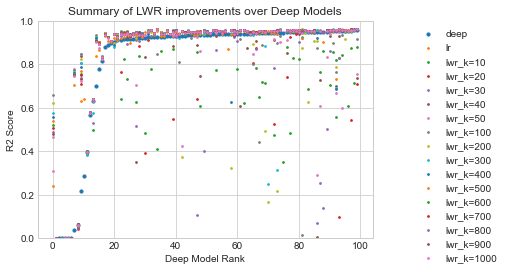

In [12]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

In [13]:
scores_df["n_features"] = [deep_models[i].n_features for i in scores_df["model_num"]] 

In [14]:
from matplotlib.colors import Colormap
import seaborn as sns #heatmap of features - pls model - score
class nlcmap(Colormap):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)
    
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)


In [15]:
subset = scores_df[["predictor","n_features","R2"]]
subset = subset[np.logical_not(subset["predictor"]=="deep")]
subset = subset[np.logical_not(subset["predictor"]=="lr")]
trans = subset["predictor"].transform(lambda x: int(x.replace("lwr_k=",""))).tolist()
subset.loc[:,"predictor"]=trans
subset=subset.sort_values("predictor",ascending=False)

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

C:\Users\huonf\AppData\Local\Temp\ipykernel_16624\3702862414.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sc,label="R2 Score")


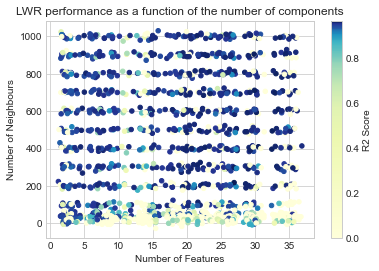

In [16]:
fig, ax = plt.subplots()
sc = ax.scatter(x=rand_jitter(subset["n_features"]), y=rand_jitter(subset["predictor"]), s=20,c=subset["R2"],cmap=cmap_nonlin,vmin=0)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Number of Neighbours")

cbar = fig.colorbar(sc,label="R2 Score")

ax.set_title("LWR performance as a function of the number of components")
plt.savefig(log_dir/f"heat_scatter.png", bbox_inches='tight')